In [2]:
import scipy
import json
import os
import numpy as np

import pandas as pd
import seaborn as sns
import scipy.stats
import statsmodels.api as sm

import matplotlib.pyplot as plt

from scipy.signal import correlate
from statsmodels.tsa.stattools import ccf

In [3]:
def load_single_contribution_attack_results(
    scenario: str,
    version: str,
    dataset: str
):
    '''Loads json file (attack results) and csv files (Shapley, LOO)
    into a one pandas dataframe'''
    
    ## Loads the json file with atack metrics
    metrics = ['TPR', 'AUC']
    json_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'nodes_attack_results.json')
    shapley_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_shapley.csv')
    loo_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_loo.csv')
    with open(json_path, 'r+') as file:
        json_file = json.load(file)
    clients_ids = [int(i) for i in json_file.keys() if i != 'average']
    iterations = [int(i) for i in json_file['0'].keys()]
    iterations.sort()
    headings = [f'{client}_{metric}' for client in clients_ids for metric in metrics]
    
    dataframe = pd.DataFrame(index=iterations, columns=headings)
    
    # Loads attack results into the frame
    for client in clients_ids:
        for iteration in iterations:
            client_data = json_file[str(client)][str(iteration)]['average']
            for heading in metrics:
                dataframe.loc[iteration, f"{client}_{heading}"] = client_data[heading]
    
    # Loads shapley into the frame
    shapley_frame = pd.read_csv(shapley_path)
    loo_frame = pd.read_csv(loo_path)
    for client in clients_ids:
        # Loads shapley values
        array = shapley_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_ACC'] = array
        array = shapley_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_F1SCORE'] = array
        
        # Loads LOO values
        array = loo_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_LOO_ACC'] = array
        array = loo_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_LOO_F1SCORE'] = array
    
    return dataframe

In [4]:
def load_single_contribution_attack_results(
    scenario: str,
    version: str,
    dataset: str
):
    '''Loads json file (attack results) and csv files (Shapley, LOO)
    into a one pandas dataframe'''
    
    ## Loads the json file with atack metrics
    metrics = ['TPR', 'AUC']
    json_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'nodes_attack_results.json')
    shapley_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_shapley.csv')
    loo_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_loo.csv')
    with open(json_path, 'r+') as file:
        json_file = json.load(file)
    clients_ids = [int(i) for i in json_file.keys() if i != 'average']
    iterations = [int(i) for i in json_file['0'].keys()]
    iterations.sort()
    headings = [f'{client}_{metric}' for client in clients_ids for metric in metrics]
    
    dataframe = pd.DataFrame(index=iterations, columns=headings)
    
    # Loads attack results into the frame
    for client in clients_ids:
        for iteration in iterations:
            client_data = json_file[str(client)][str(iteration)]['average']
            for heading in metrics:
                dataframe.loc[iteration, f"{client}_{heading}"] = client_data[heading]
    
    # Loads shapley into the frame
    shapley_frame = pd.read_csv(shapley_path)
    loo_frame = pd.read_csv(loo_path)
    for client in clients_ids:
        # Loads shapley values
        array = shapley_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_ACC'] = array
        array = shapley_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_F1SCORE'] = array
        
        # Loads LOO values
        array = loo_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_LOO_ACC'] = array
        array = loo_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_LOO_F1SCORE'] = array
    
    return dataframe

In [5]:
def load_multiple_contribution_attack_results(
    scenarios: list[str],
    versions: list[str],
    datasets: list[str]
):
    all_results = {
        f"{scenario}_{version}_{dataset}" : None
        for scenario in scenarios
        for version in versions
        for dataset in datasets
    }
    for scenario in scenarios:
        for version in versions:
            for dataset in datasets:
                key = f"{scenario}_{version}_{dataset}"
                all_results[key] = load_single_contribution_attack_results(
                    scenario=scenario,
                    version=version,
                    dataset=dataset
                    )
    return all_results

In [6]:
def calculate_single_corr(
    no_clients: int,
    frame: pd.DataFrame,
    mode: 'str'
):
    if mode == 'spearman':
        correlation = scipy.stats.spearmanr
    elif mode =='pearson':
        correlation = scipy.stats.pearsonr
    else:
        assert NameError
    corr_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        corr_frame.loc[client, 'TPR_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_ACC']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_ACC']
        ).statistic
        corr_frame.loc[client, 'TPR_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_F1SCORE']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_F1SCORE']
        ).statistic
        
        corr_frame.loc[client, 'TPR_TO_LOO_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_ACC']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_LOO_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_ACC']
        ).statistic
        corr_frame.loc[client, 'TPR_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_F1SCORE']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_F1SCORE']
        ).statistic
    return corr_frame

In [7]:
def calculate_single_stationarity(
    no_clients: int,
    frame: pd.DataFrame,
):
    statio_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        tpr_results = sm.tsa.stattools.adfuller(frame[f'{client}_TPR'])
        shap_results = sm.tsa.stattools.adfuller(frame[f'{client}_SHAP_F1SCORE'])
        
        statio_frame.loc[client, 'TPR ADF Statistic'] = tpr_results[0]
        statio_frame.loc[client, 'TPR ADF p-value'] = tpr_results[1]
        statio_frame.loc[client, 'SHAP ADF Statistic'] = shap_results[0]
        statio_frame.loc[client, 'SHAP ADF p-value'] = shap_results[1]

    return statio_frame

In [8]:
def calculate_single_corr_short(
    no_clients: int,
    frame: pd.DataFrame,
    mode: 'str'
):
    if mode == 'spearman':
        correlation = scipy.stats.spearmanr
    elif mode =='pearson':
        correlation = scipy.stats.pearsonr
    else:
        assert NameError
    corr_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        corr = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_ACC']
        )
        corr_frame.loc[client, 'TPR_TO_SHAP_ACC CORR'] = corr.statistic
        corr_frame.loc[client, 'TPR_TO_SHAP_ACC P-VALUE'] = corr.pvalue
        
        corr = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_F1SCORE']
        )
        
        corr_frame.loc[client, 'TPR_TO_SHAP_F1SCORE'] = corr.statistic
        corr_frame.loc[client, 'TPR_TO_SHAP_F1SCORE P-VALUE'] = corr.pvalue
        
    return corr_frame

In [9]:
def calculate_single_crosscor(
    no_clients: int,
    no_round: int,
    frame: pd.DataFrame,
    shift: int
):
    crosscorr_frame = pd.DataFrame(index=range(no_round * 2 - 1), columns=[f"client_{client}" for client in range(no_clients)])
    
    for client in range(no_clients):
        series_X = frame[f'{client}_TPR']
        series_Y = np.roll(frame[f'{client}_SHAP_ACC'], shift=shift)
        crosscorr_frame[f"client_{client}"] = np.array(correlate(series_X - np.mean(series_X), series_Y - np.mean(series_Y), mode="full"))
    
    return crosscorr_frame

In [10]:
def calculate_multiple_stationarity(
    results : dict,
    no_clients : int,
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_stationarity(frame=frame, no_clients=no_clients)
    return all_results

In [11]:
def calculate_multiple_corr(
    results : dict,
    no_clients : int,
    mode : str
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_corr(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

In [12]:
def calculate_multiple_corr_short(
    results : dict,
    no_clients : int,
    mode : str
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_corr_short(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

In [13]:
def calculate_multiple_stat(
    results : dict,
    no_clients : int,
    mode : str
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_corr(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

In [14]:
def calculate_multiple_crosscorr(
    results : dict,
    no_clients : int,
    no_round : int,
    shift : int
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_crosscor(frame=frame, no_clients=no_clients, no_round=no_round, shift=shift)
    return all_results

In [15]:
def calculate_single_pvalue(
    no_clients: int,
    frame: pd.DataFrame,
    mode: 'str'
):
    if mode == 'spearman':
        correlation = scipy.stats.spearmanr
    elif mode =='pearson':
        correlation = scipy.stats.pearsonr
    else:
        assert NameError
    corr_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        corr_frame.loc[client, 'TPR_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_ACC']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_ACC']
        ).pvalue
        corr_frame.loc[client, 'TPR_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_F1SCORE']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_F1SCORE']
        ).pvalue
        
        corr_frame.loc[client, 'TPR_TO_LOO_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_ACC']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_LOO_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_ACC']
        ).pvalue
        corr_frame.loc[client, 'TPR_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_F1SCORE']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_F1SCORE']
        ).pvalue
    return corr_frame

In [16]:
def calculate_multiple_pvalues(
    results : dict,
    no_clients : int,
    mode : str
):
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_pvalue(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

# Part 4.1.: Visual Inspection of the Relationship (full)

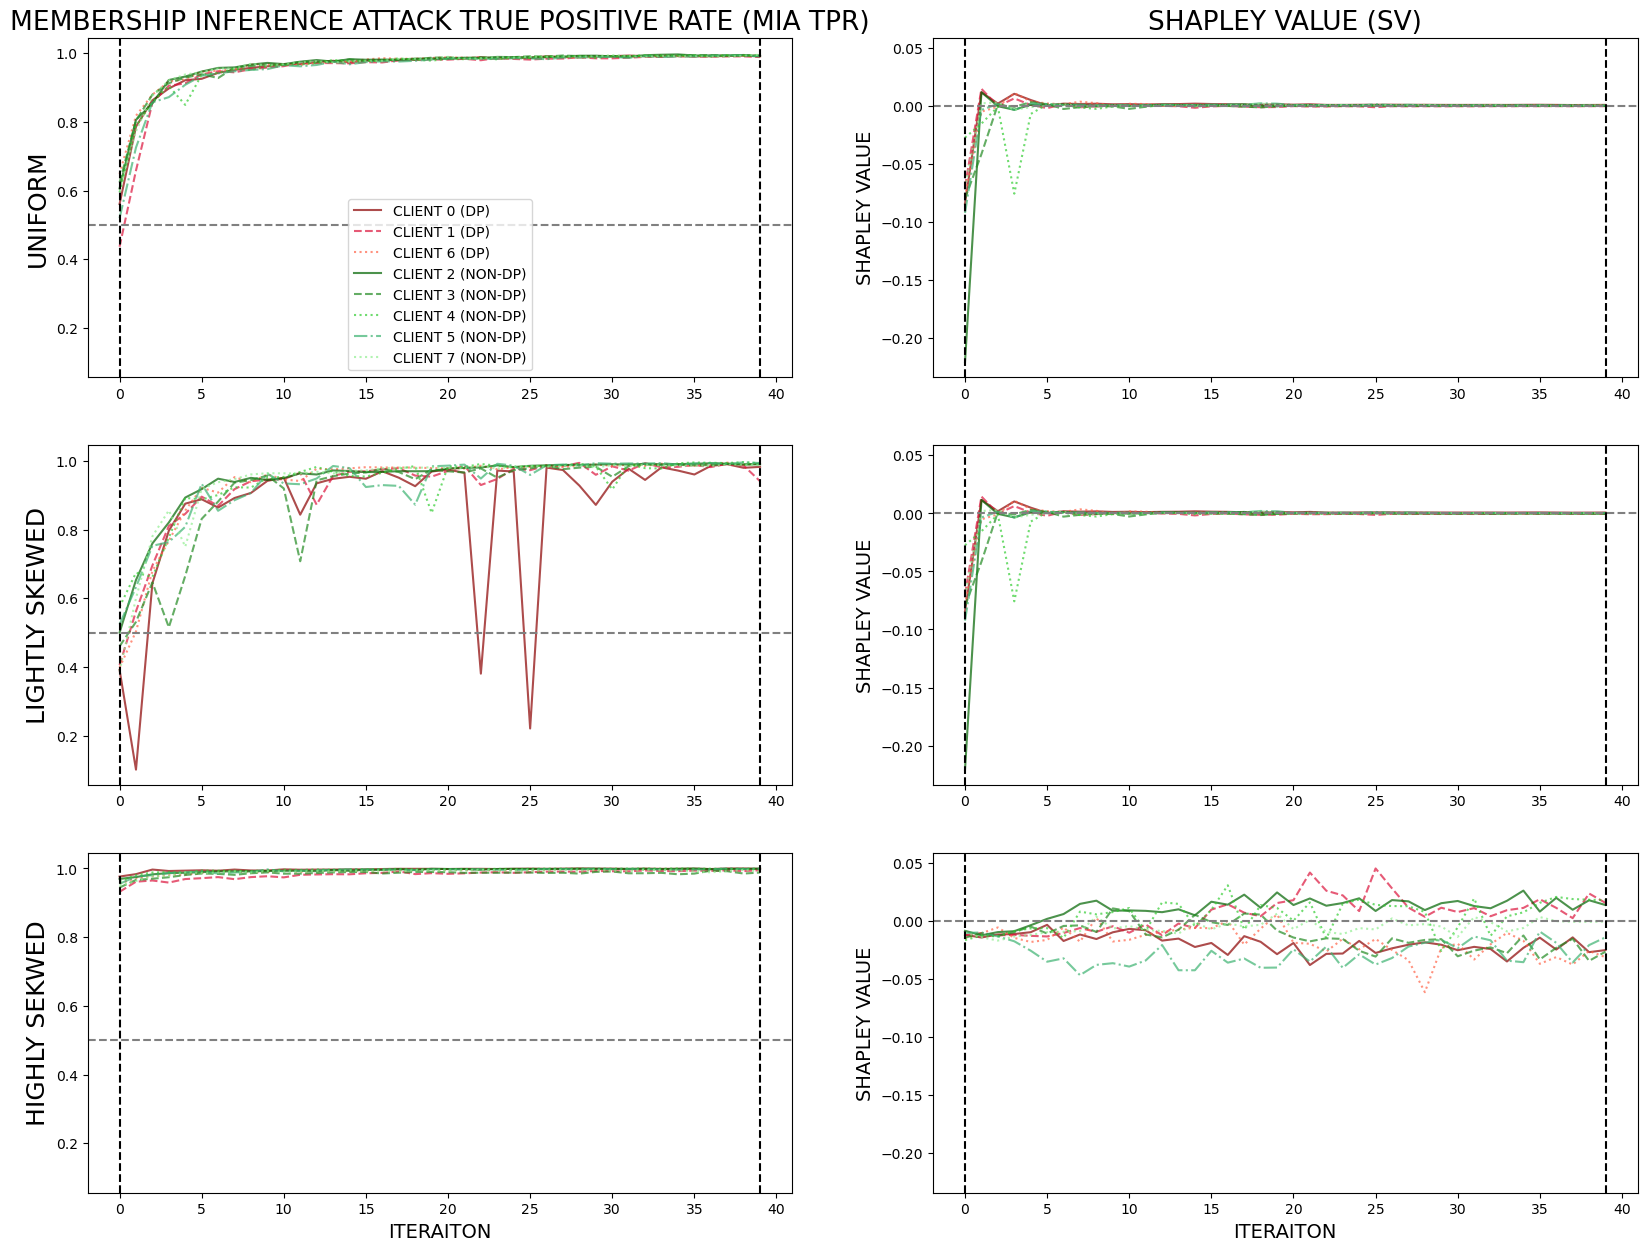

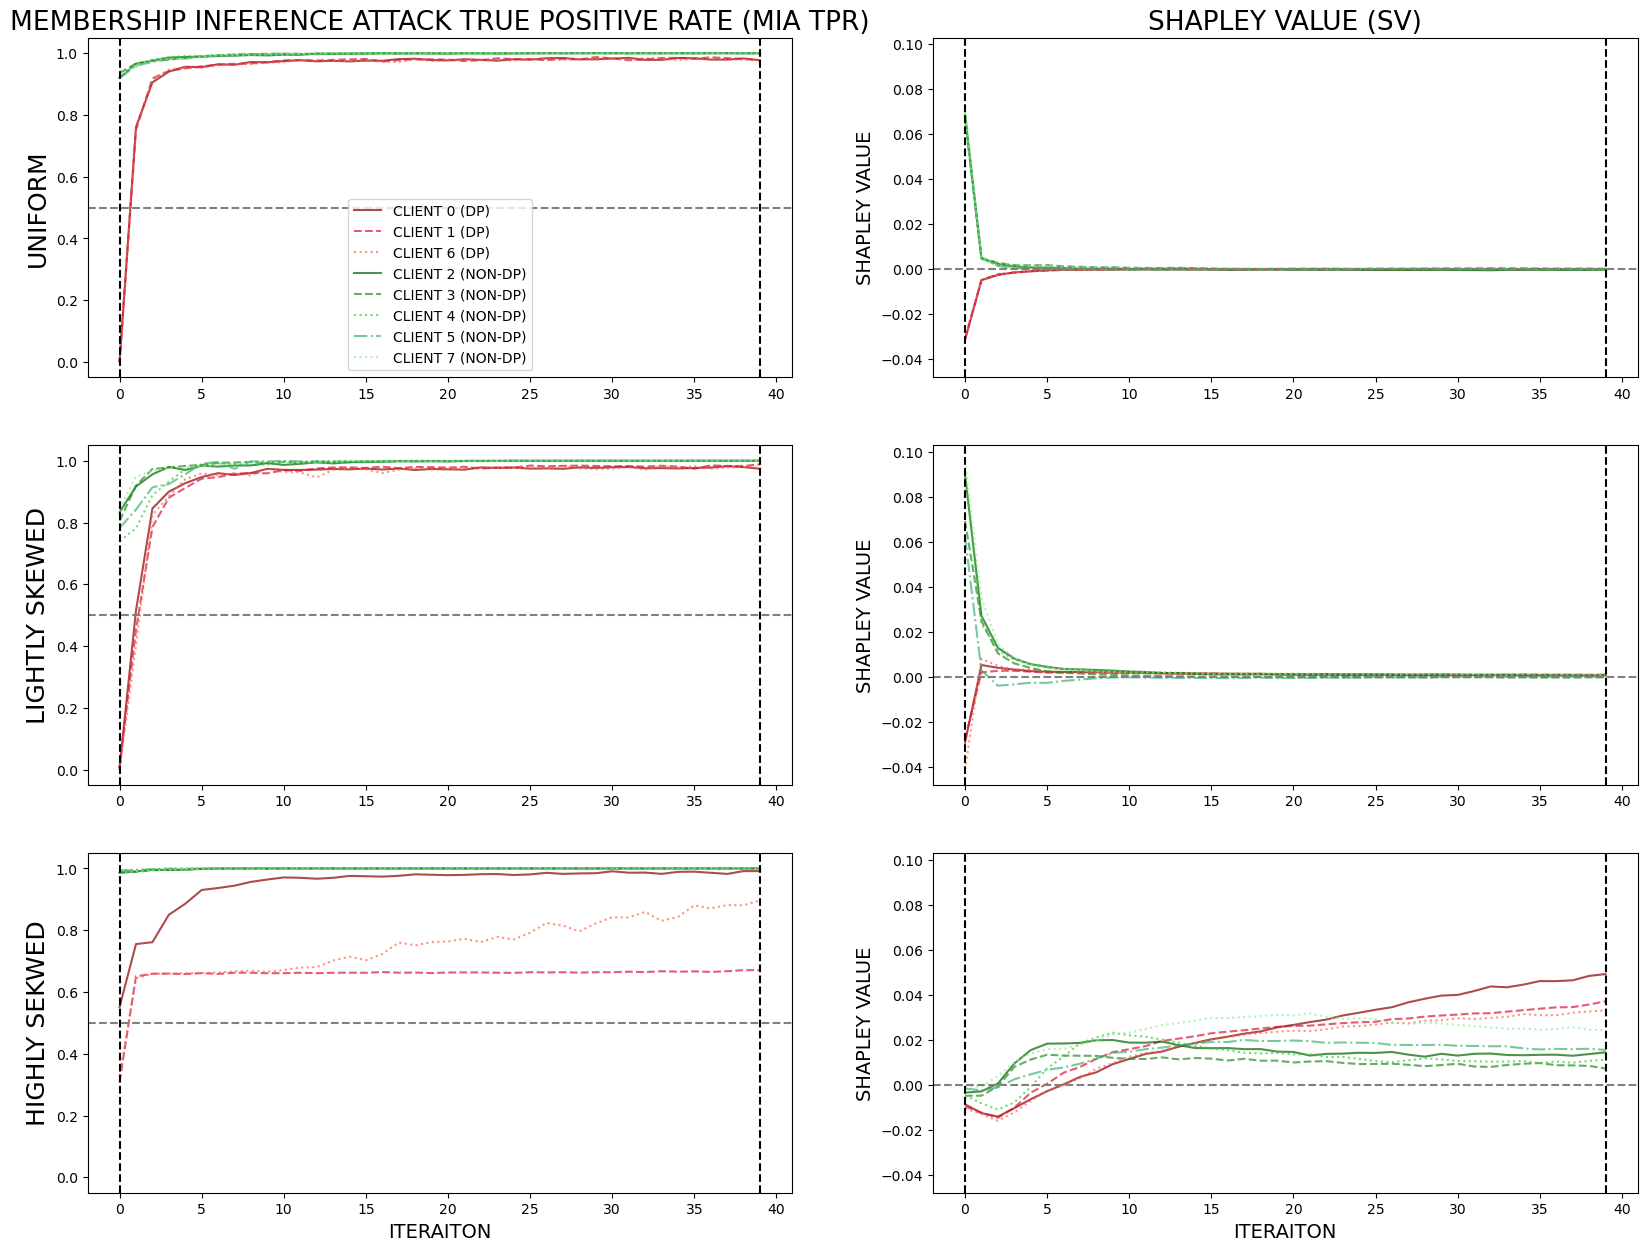

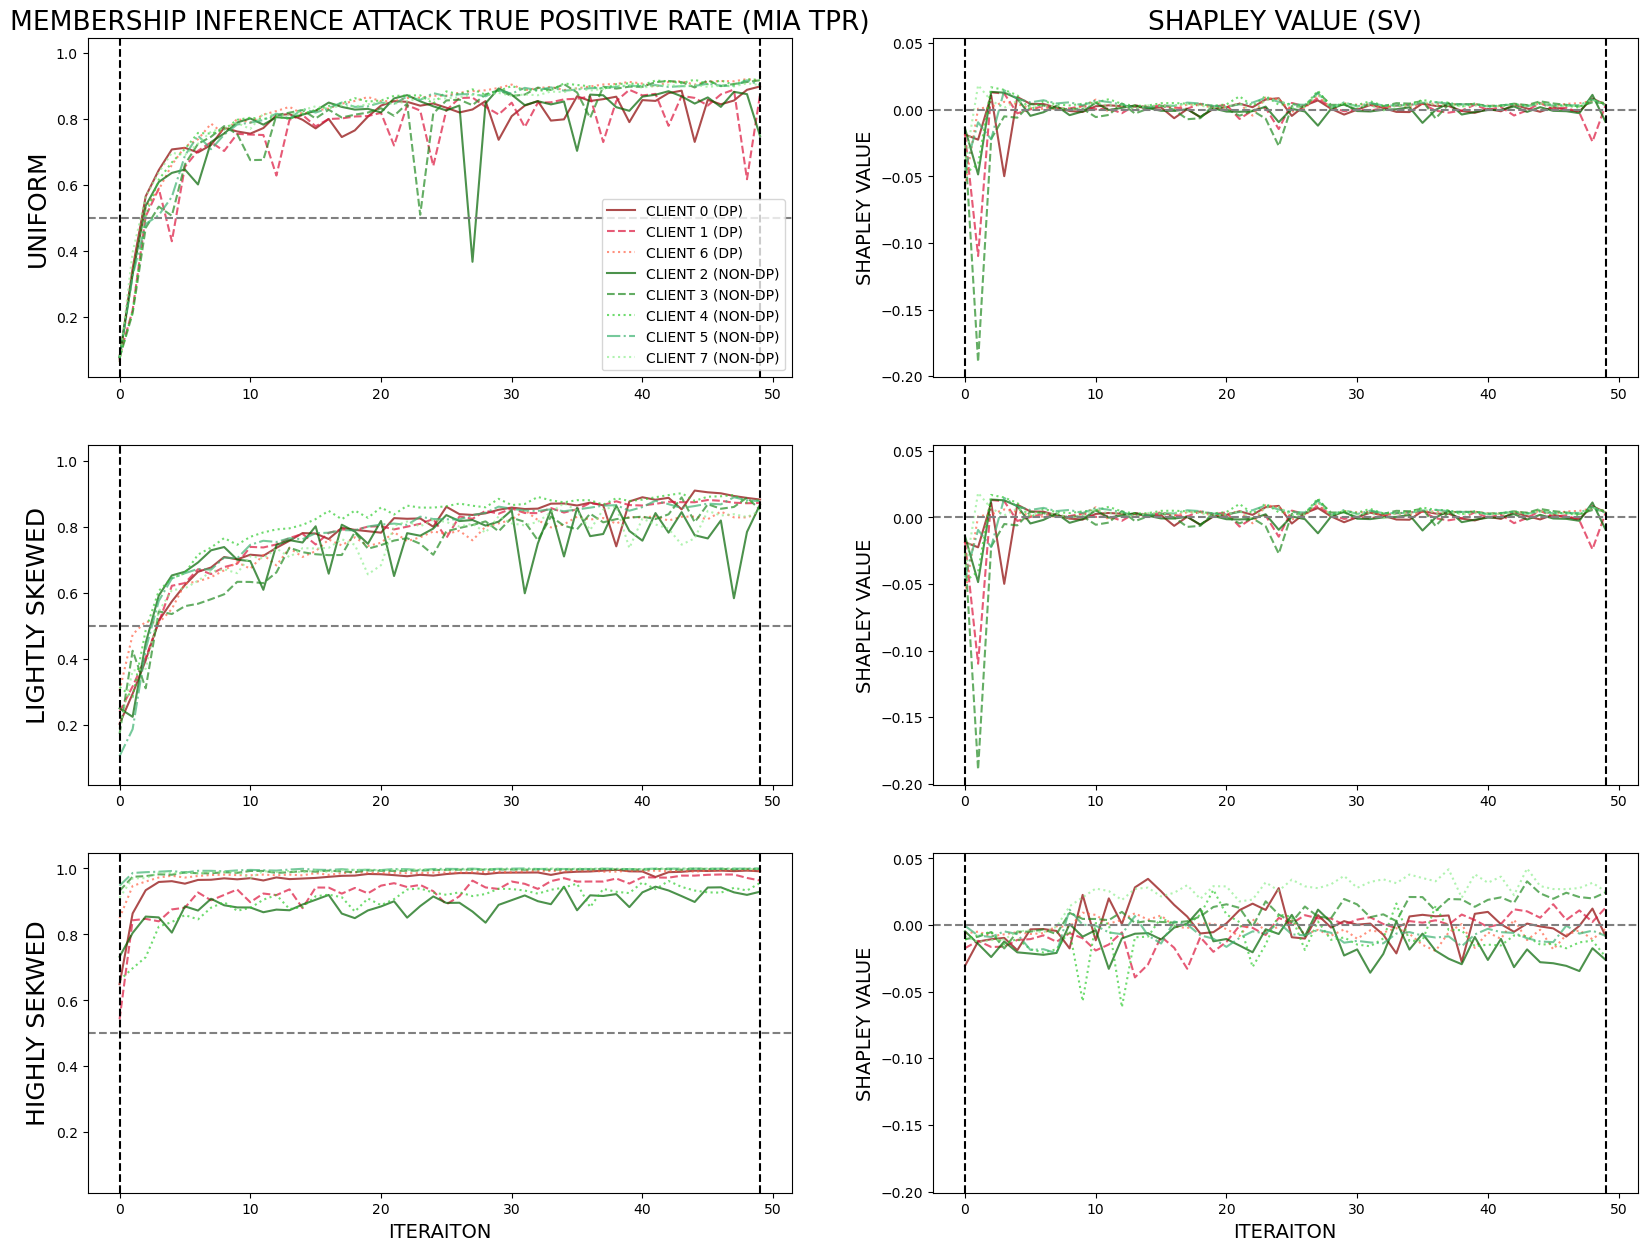

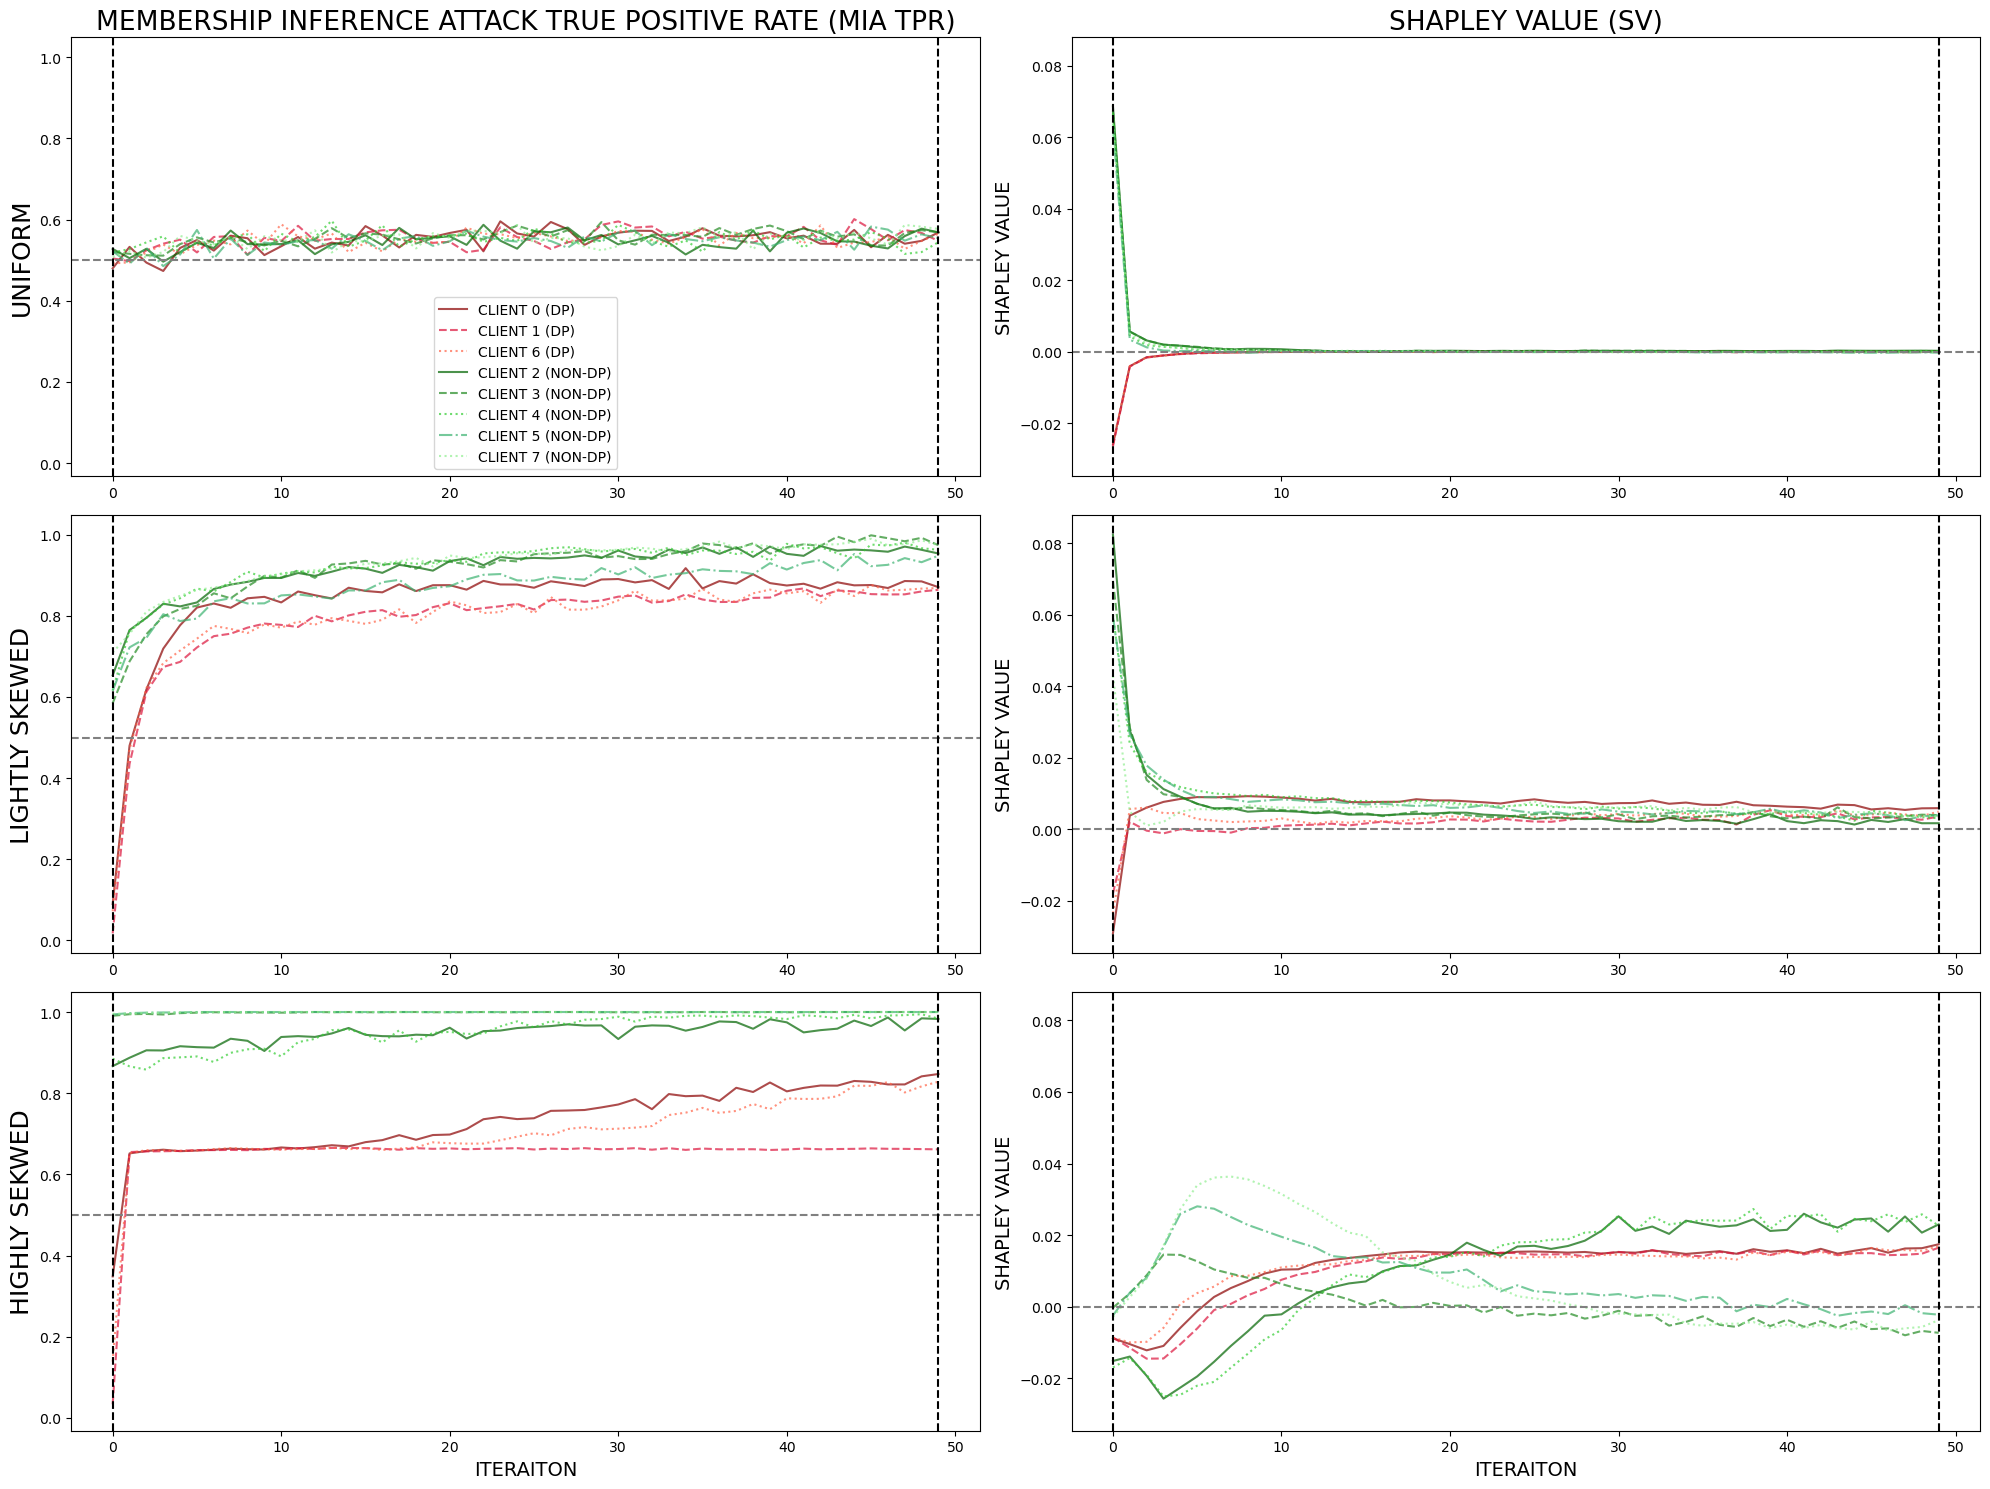

In [17]:
datasets = ['mnist', 'fmnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP', 'with_DP']

client_styles = {
    0: ('#8B0000', '-'),   # Dark Red (Solid)
    1: ('#DC143C', '--'),  # Crimson Red (Dashed)
    6: ('#FF6347', ':'),   # Tomato Red (Dotted)
    2: ('#006400', '-'),   # Dark Green (Solid)
    3: ('#228B22', '--'),  # Forest Green (Dashed)
    4: ('#32CD32', ':'),   # Lime Green (Dotted)
    5: ('#3CB371', '-.'),  # Medium Sea Green (Dash-Dot)
    7: ('#90EE90', ':')   # Light Green (Densely Dotted)
}

for dataset in datasets:
    for version in versions:
        
        fig, axes = plt.subplots(3, 2, figsize=(20, 15))
        results_MNIST = load_multiple_contribution_attack_results(
            datasets=[dataset],
            scenarios=scenarios,
            versions=[version]
        )

        for scenario, axs in zip(scenarios, axes):
            for client in [0, 1, 6]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
            for client in [2, 3, 4, 5, 7]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
    
        axes[0,0].legend()
        axes[0,0].set_title("MEMBERSHIP INFERENCE ATTACK TRUE POSITIVE RATE (MIA TPR)", fontsize=19)
        axes[0,1].set_title("SHAPLEY VALUE (SV)", fontsize=19)

        axes[0,0].set_ylabel('UNIFORM', fontsize=18)
        axes[1,0].set_ylabel('LIGHTLY SKEWED', fontsize=18)
        axes[2,0].set_ylabel('HIGHLY SEKWED', fontsize=18)

        axes[1][0].sharey(axes[0][0])
        axes[2][0].sharey(axes[0][0])
        axes[1][1].sharey(axes[0][1])
        axes[2][1].sharey(axes[0][1])

        if dataset == 'mnist':
            x = 39
        else:
            x = 49
        for i in range(3):
            axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
            axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
            axes[i][0].axvline(x=0, color='black', linestyle='--')
            axes[i][0].axvline(x=x, color='black', linestyle='--')
            axes[i][1].axvline(x=0, color='black', linestyle='--')
            axes[i][1].axvline(x=x, color='black', linestyle='--')
        for i in range(2):
            axes[2][i].set_xlabel("ITERAITON", fontsize=14)
        for i in range(3):
            axes[i][1].set_ylabel("SHAPLEY VALUE", fontsize=14)
        
        if version == 'with_DP':
            suptitle = "(SOME CLIENTS WITH DP)"
        else:
            suptitle = "(WITHOUT ANY DP)"
        #fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)

fig.tight_layout()

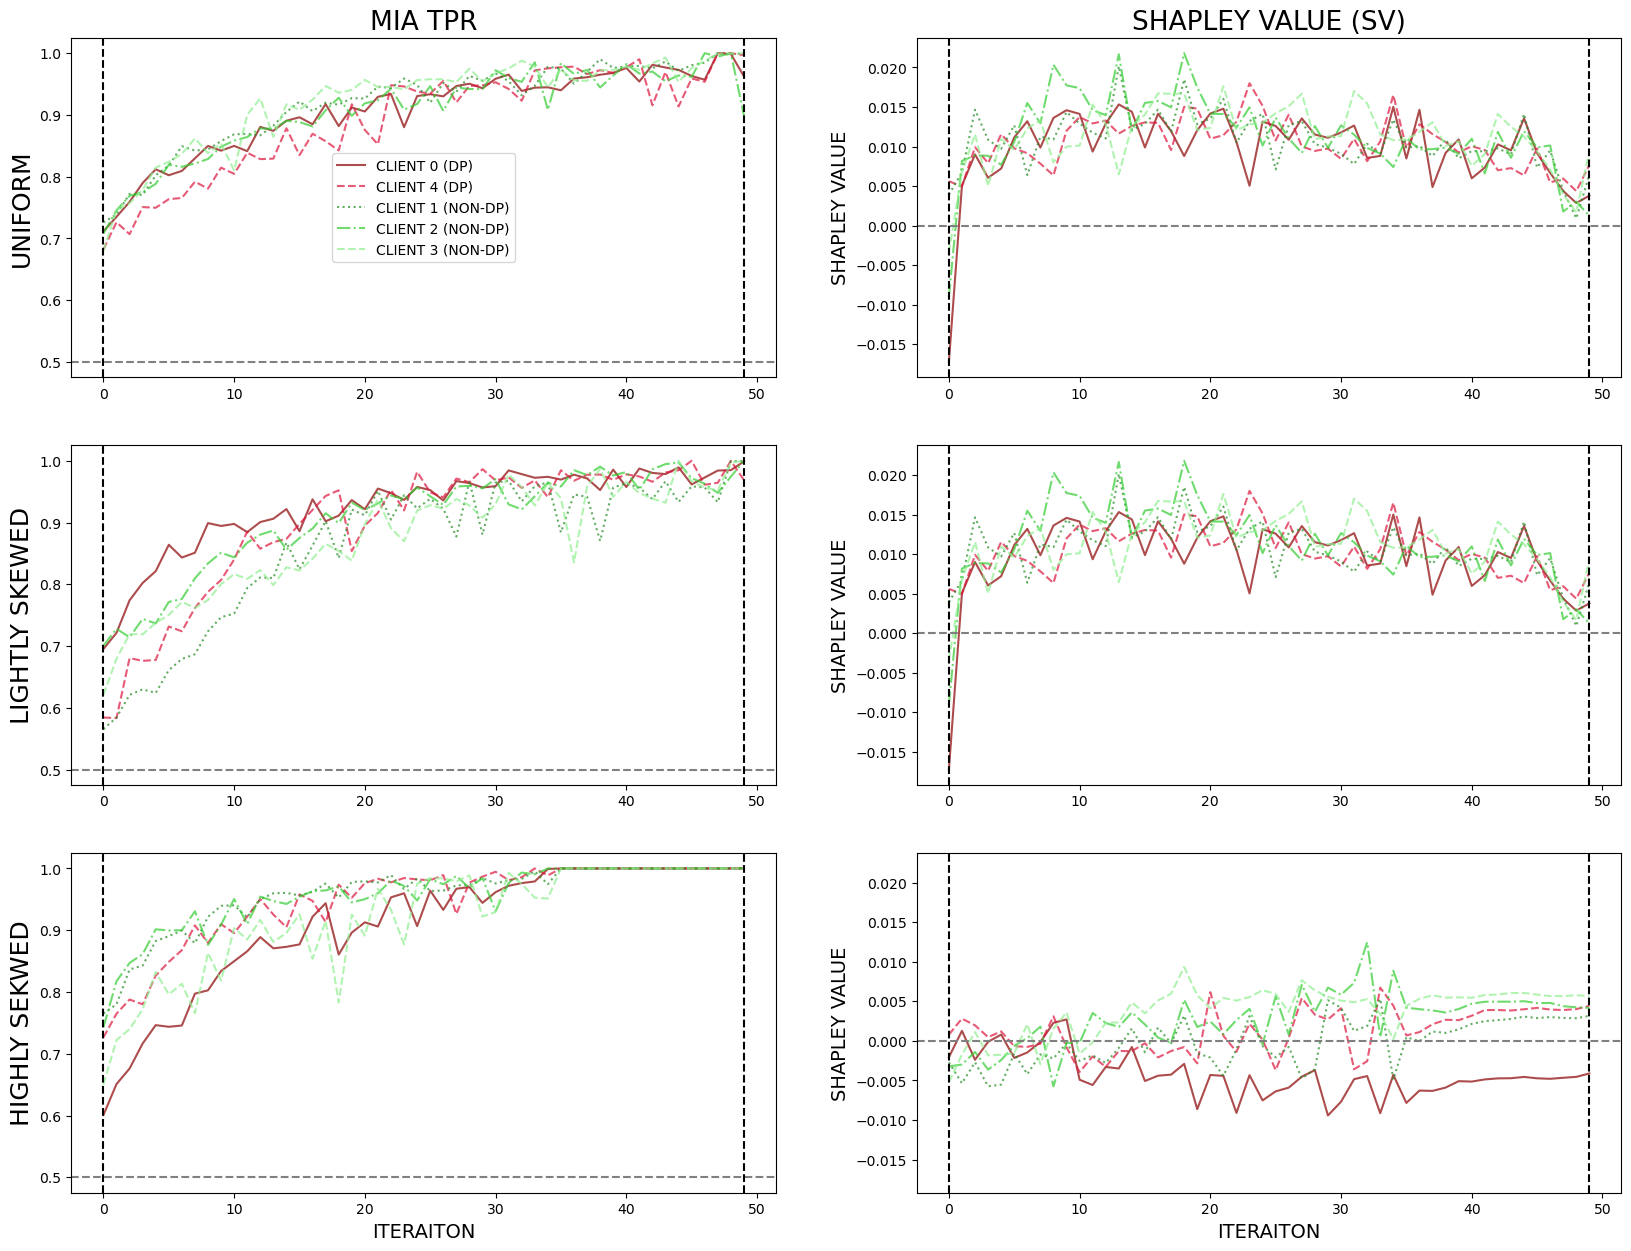

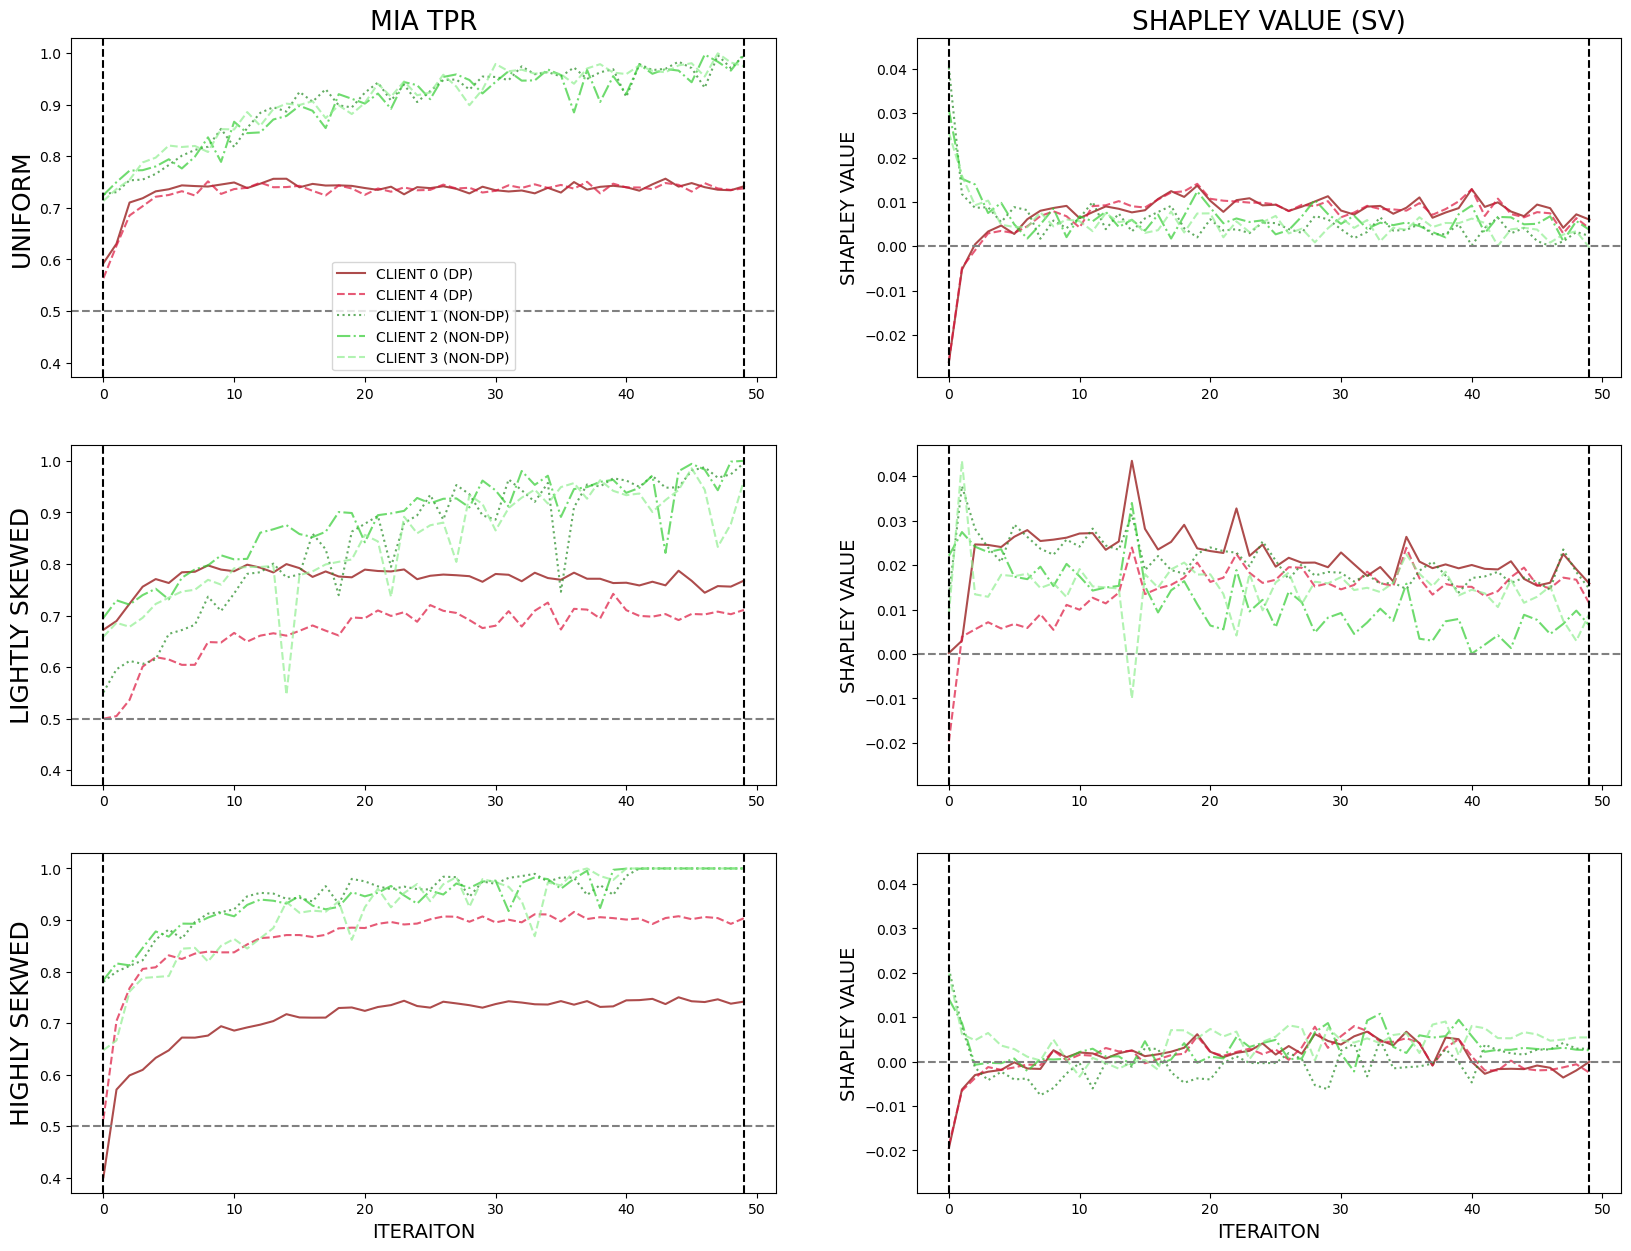

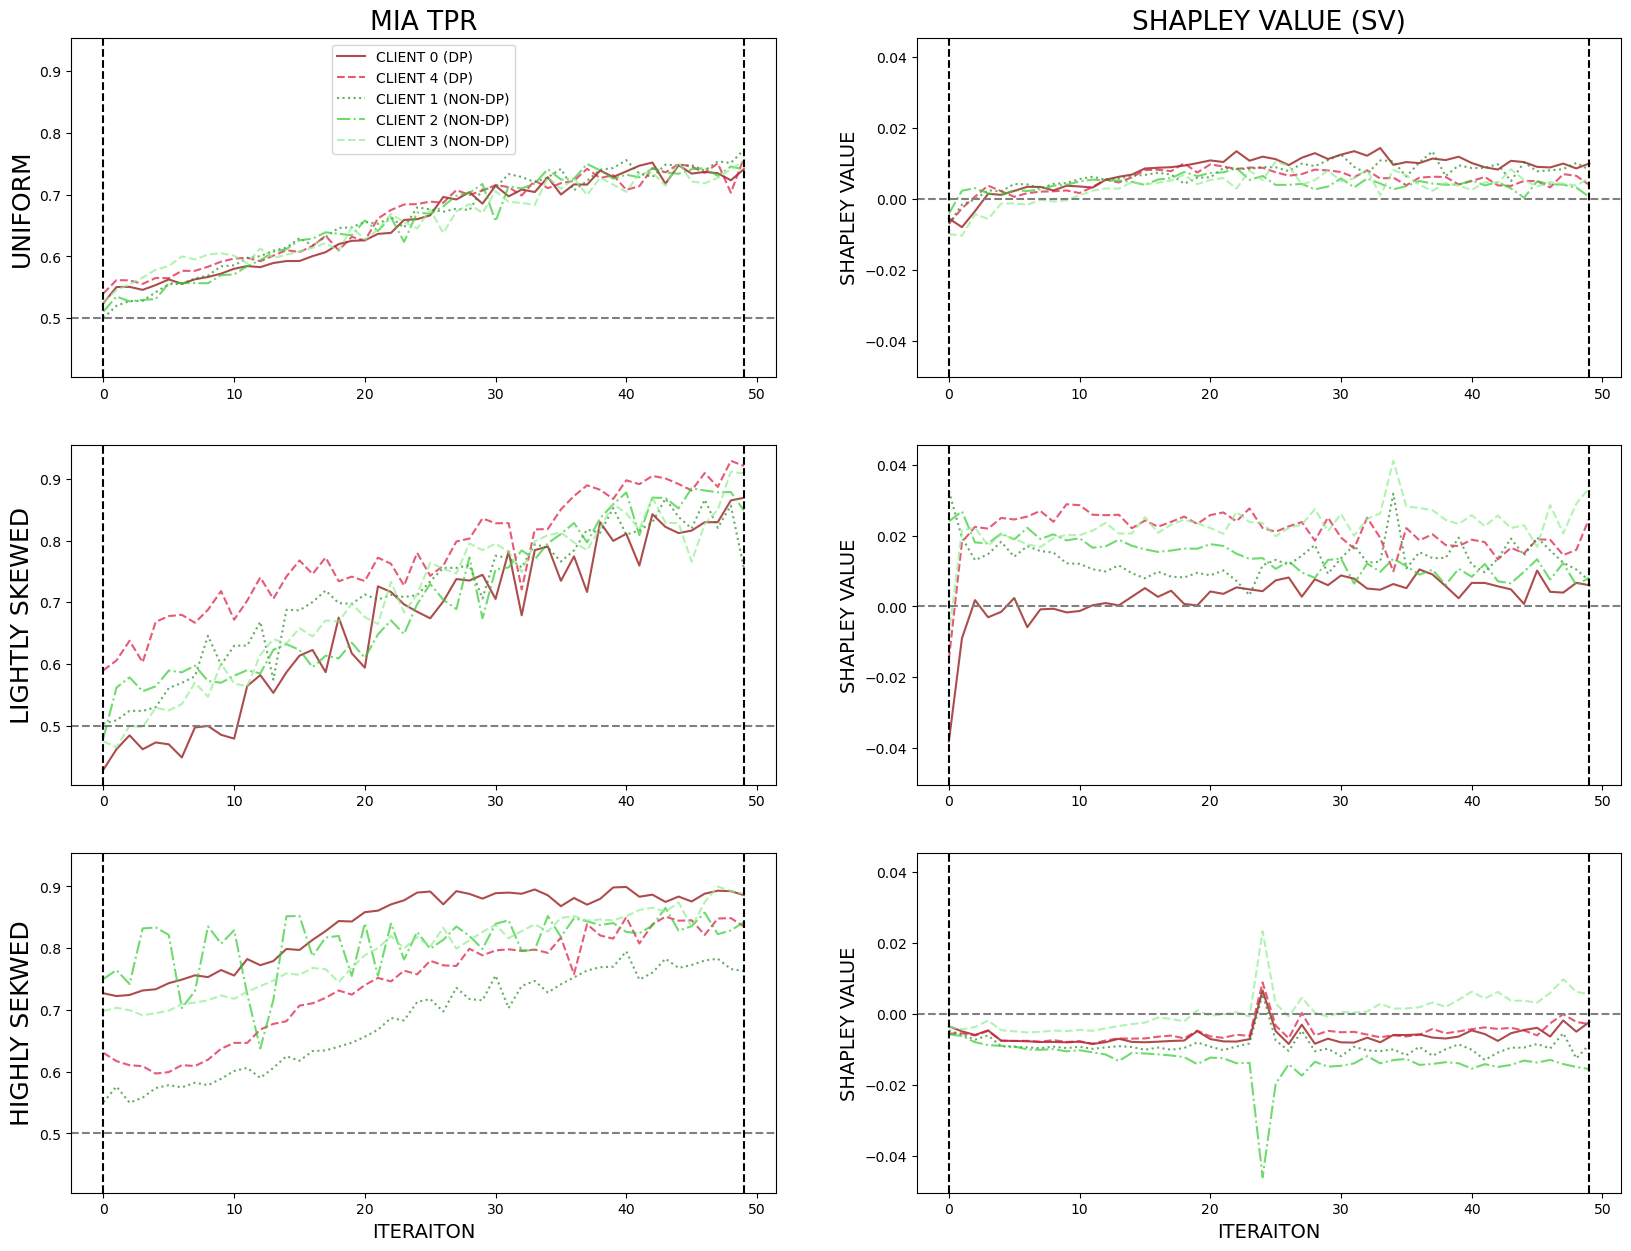

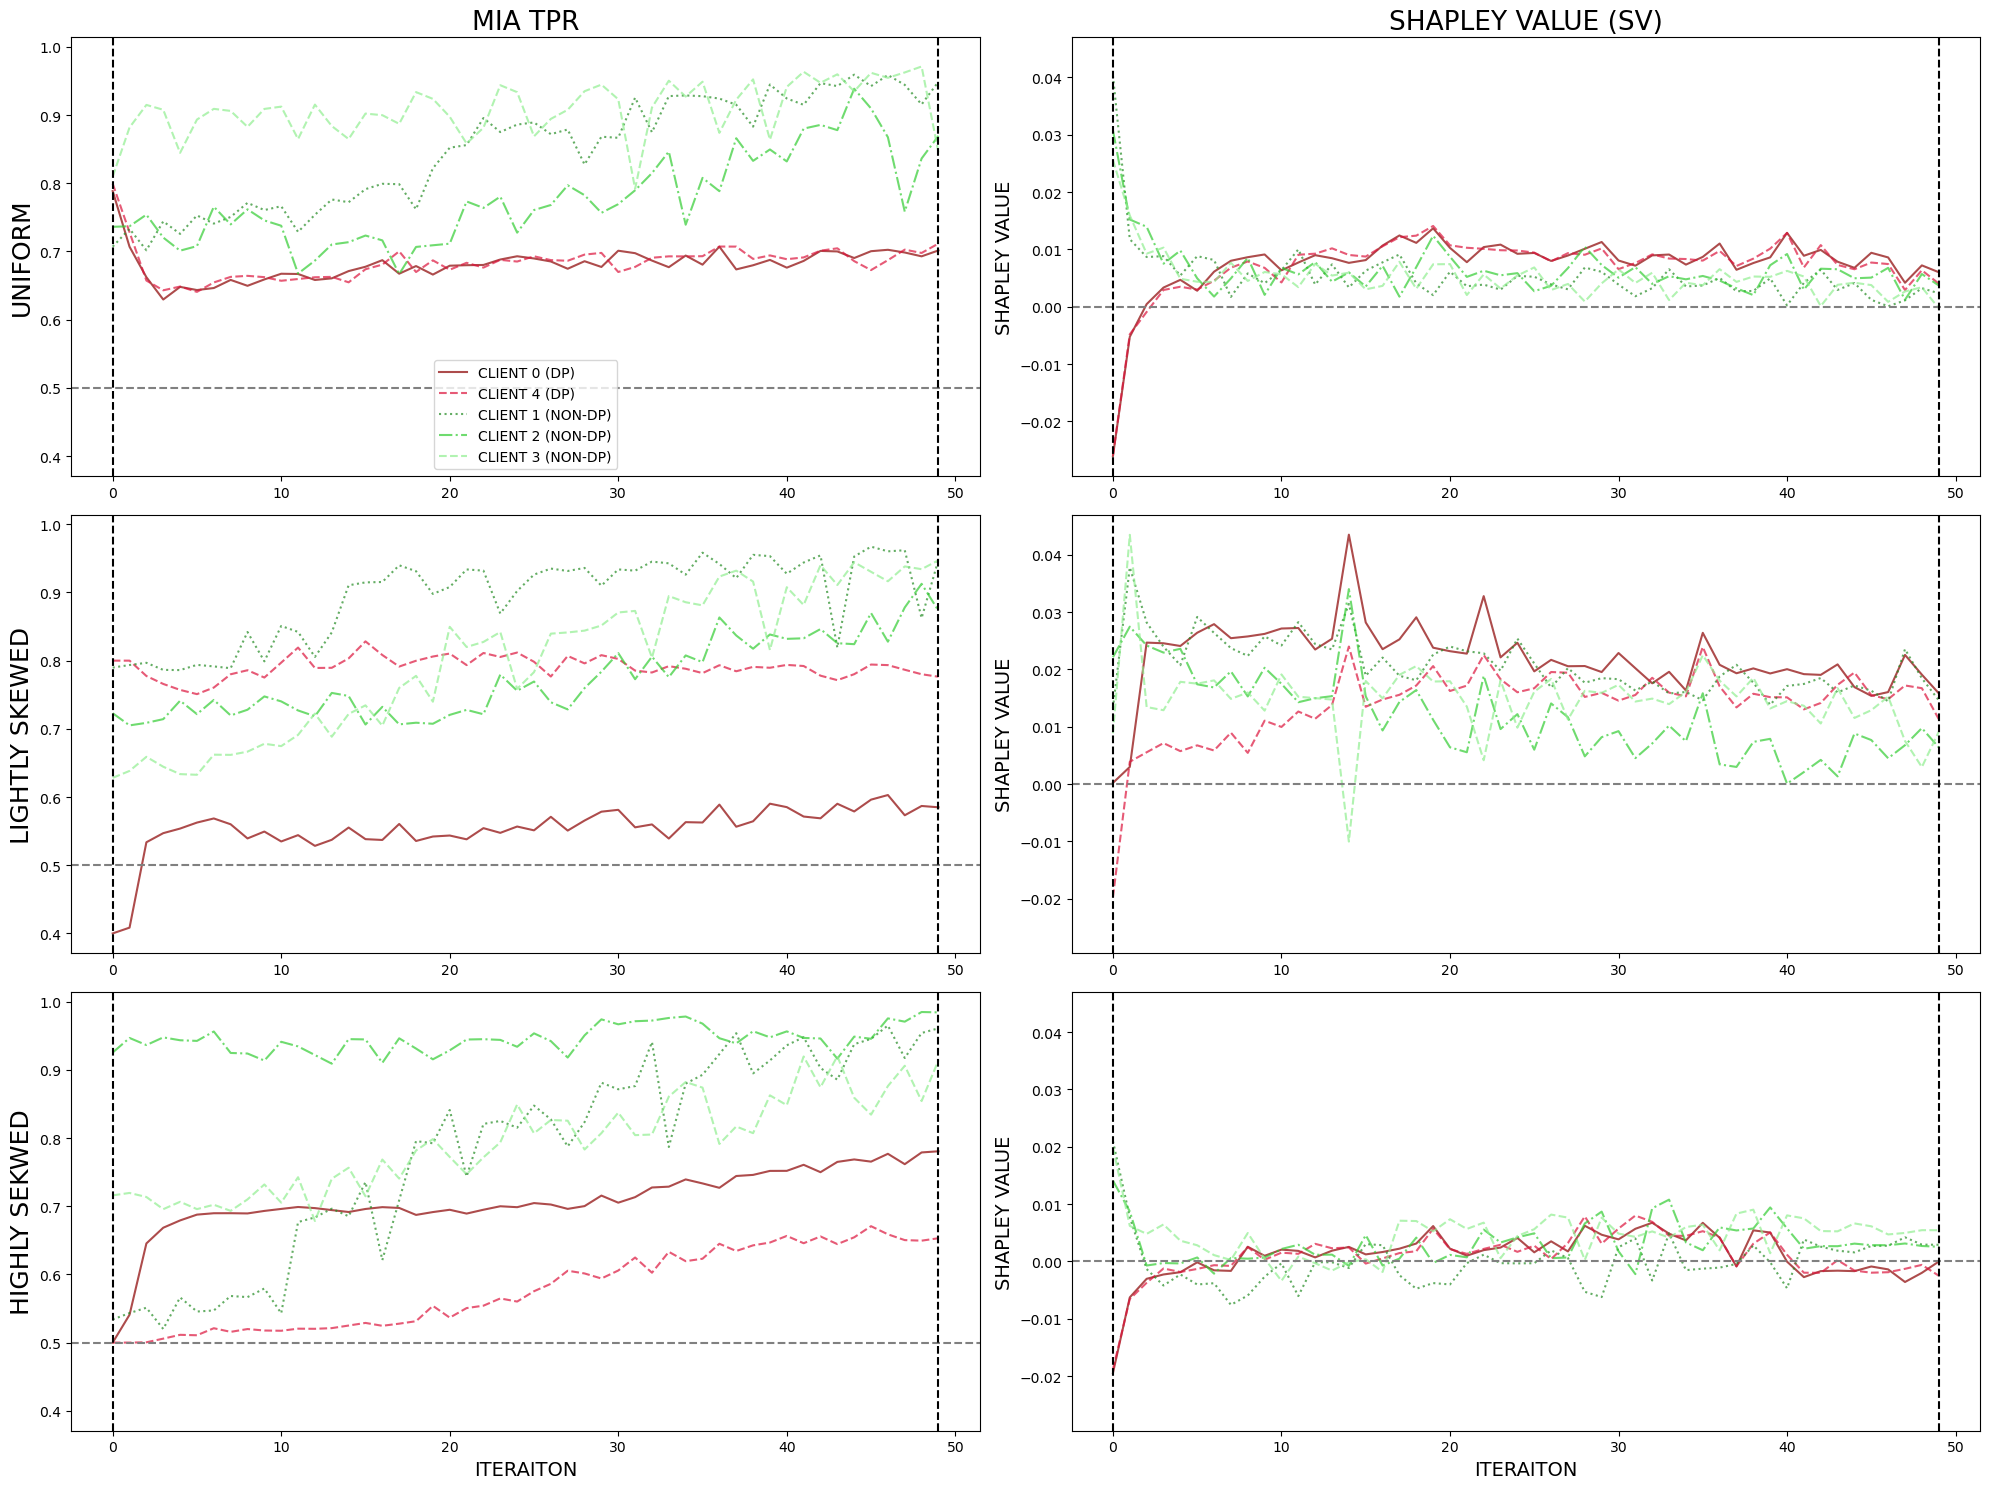

In [18]:
datasets = ['cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP', 'with_DP']

client_styles = {
    0: ('#8B0000', '-'),   # Dark Red (Solid)
    4: ('#DC143C', '--'),  # Crimson Red (Dashed)
    1: ('#228B22', ':'),   # Forest Green (Dotted)
    2: ('#32CD32', '-.'),  # Lime Green (Dash-Dot)
    3: ('#90EE90', '--')   # Light Green (Densely Dotted)
}

for dataset in datasets:
    for version in versions:
        
        fig, axes = plt.subplots(3, 2, figsize=(20, 15))
        results_MNIST = load_multiple_contribution_attack_results(
            datasets=[dataset],
            scenarios=scenarios,
            versions=[version]
        )

        for scenario, axs in zip(scenarios, axes):
            for client in [0, 4]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
            for client in [1, 2, 3]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
    
        axes[0,0].legend()
        axes[0,0].set_title("MIA TPR", fontsize=19)
        axes[0,1].set_title("SHAPLEY VALUE (SV)", fontsize=19)

        axes[0,0].set_ylabel('UNIFORM', fontsize=18)
        axes[1,0].set_ylabel('LIGHTLY SKEWED', fontsize=18)
        axes[2,0].set_ylabel('HIGHLY SEKWED', fontsize=18)

        axes[1][0].sharey(axes[0][0])
        axes[2][0].sharey(axes[0][0])
        axes[1][1].sharey(axes[0][1])
        axes[2][1].sharey(axes[0][1])

        x = 49
        for i in range(3):
            axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
            axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
            axes[i][0].axvline(x=0, color='black', linestyle='--')
            axes[i][0].axvline(x=x, color='black', linestyle='--')
            axes[i][1].axvline(x=0, color='black', linestyle='--')
            axes[i][1].axvline(x=x, color='black', linestyle='--')
        for i in range(2):
            axes[2][i].set_xlabel("ITERAITON", fontsize=14)
        for i in range(3):
            axes[i][1].set_ylabel("SHAPLEY VALUE", fontsize=14)
        
        if version == 'with_DP':
            suptitle = "(SOME CLIENTS WITH DP)"
        else:
            suptitle = "(WITHOUT ANY DP)"
        #fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)

fig.tight_layout()

# Part 4.1.: Visual Inspection of the Relationship (averaged)

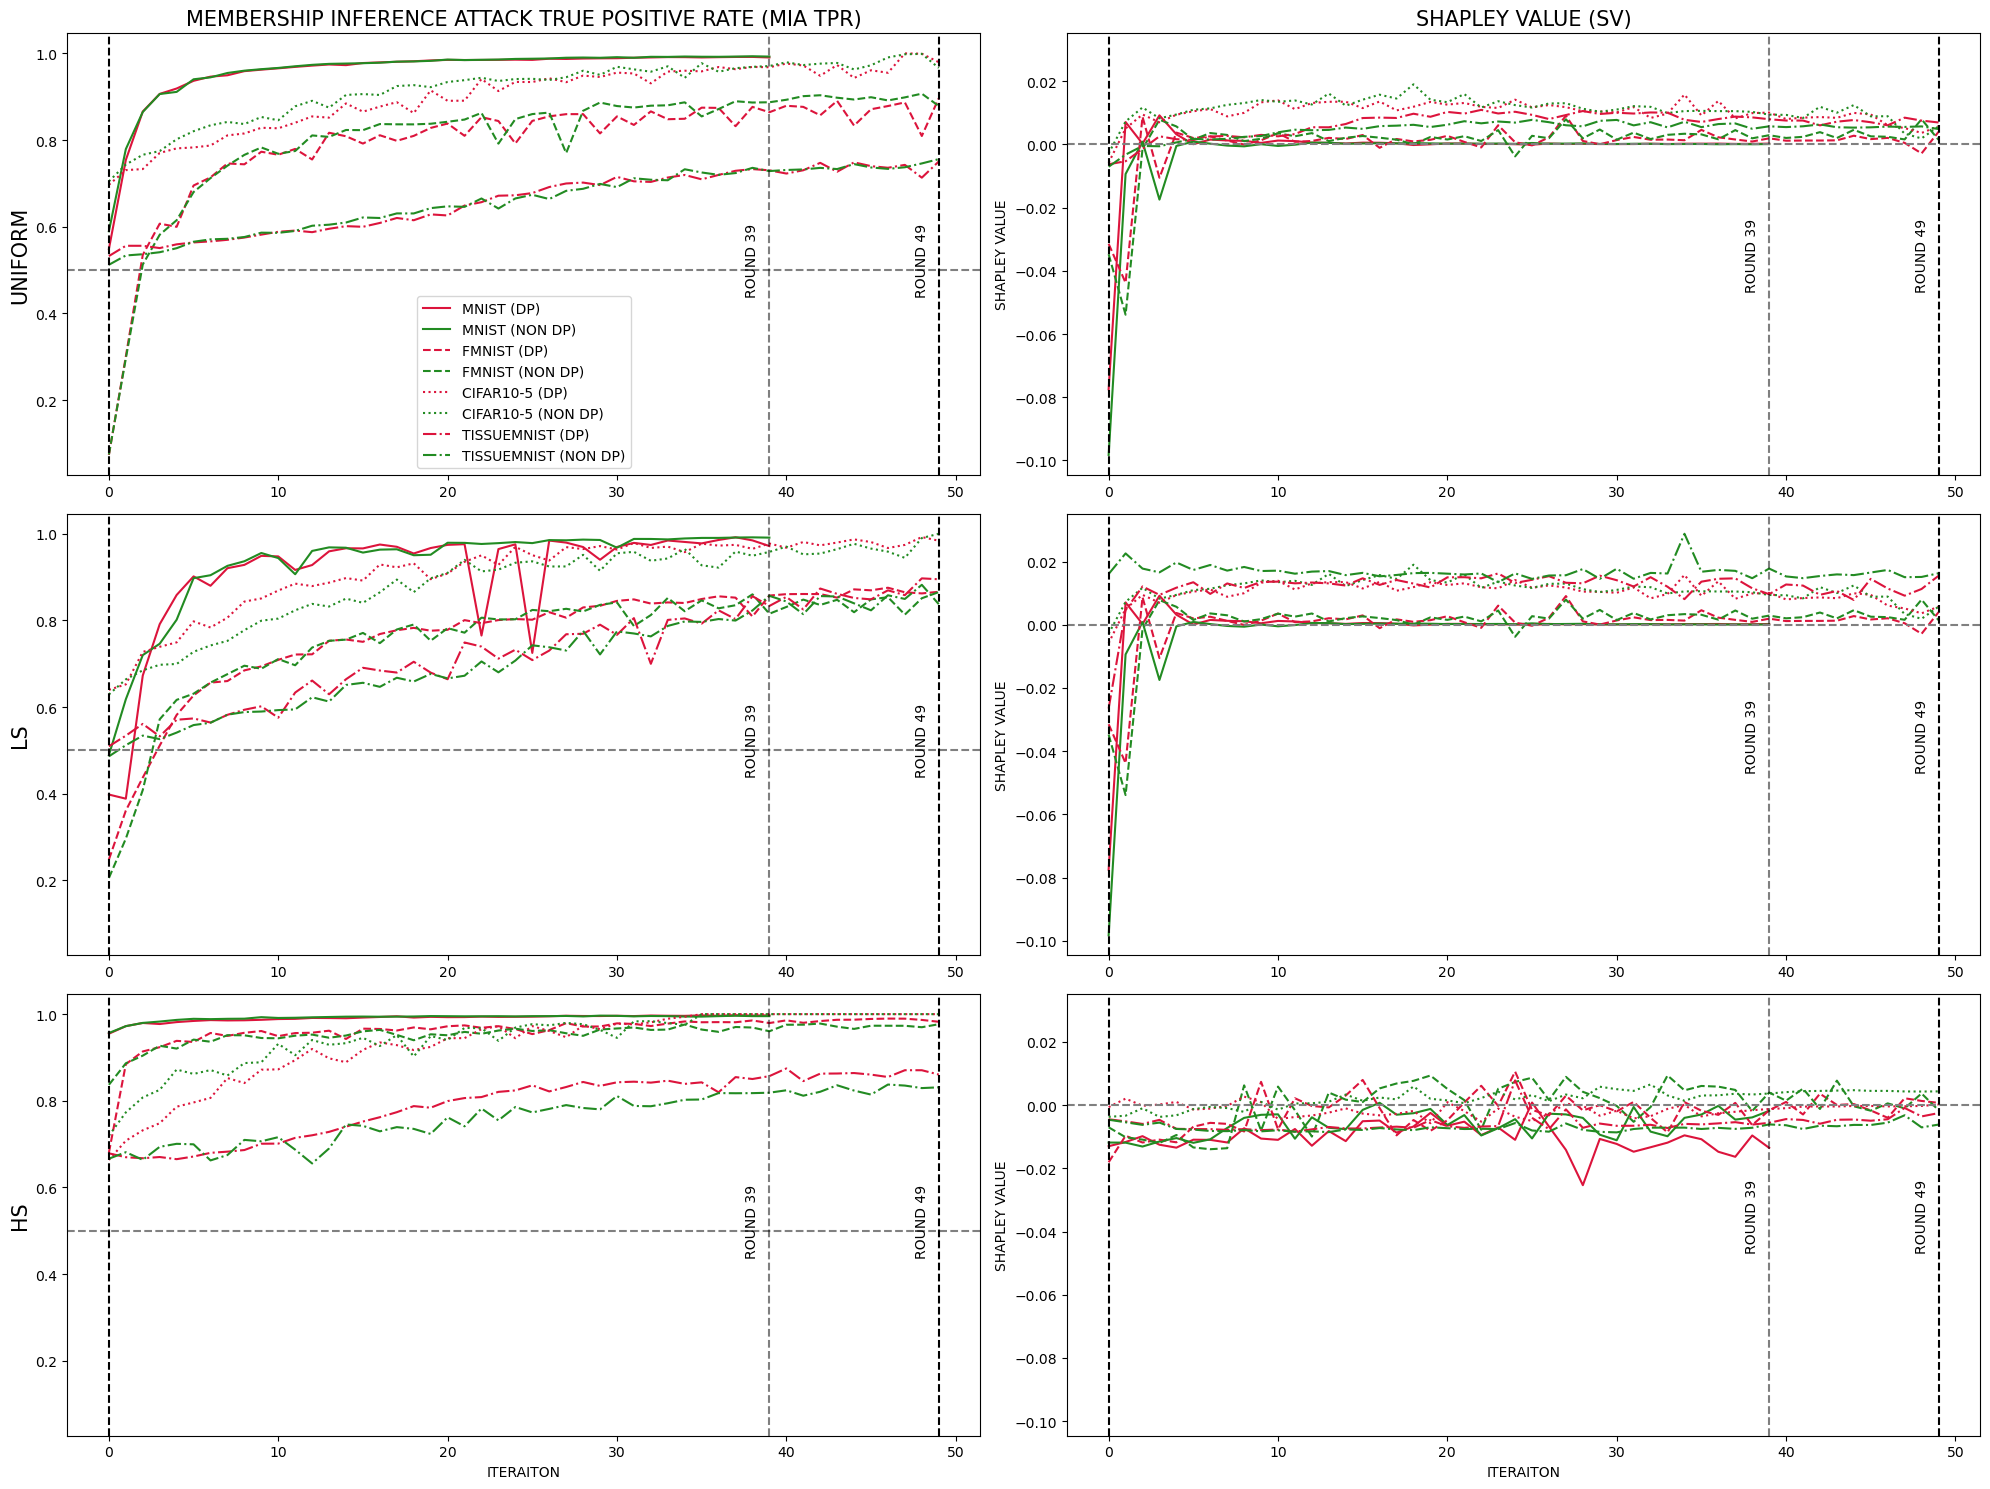

In [19]:
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP']

client_styles = {
    'mnist': '-',  # Blue
    'fmnist': '--', # Red 
    'cifar10-5': ':',  # Green 
    'tissuemnist': '-.', # Orange 
}


results = load_multiple_contribution_attack_results(
            datasets=datasets,
            scenarios=scenarios,
            versions=versions
)
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

for dataset in datasets:
    if dataset == 'mnist' or dataset == 'fmnist':
        dp_clients = [0, 1, 6]
        non_dp_clients = [2, 3, 4, 5, 7]
    else:
        dp_clients = [0, 4]
        non_dp_clients = [1, 2, 3]
    
    axes[0][0].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset], label=f"{dataset} (DP)".upper())
    axes[1][0].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    axes[2][0].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
    axes[0][0].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset], label=f"{dataset} (NON DP)".upper())
    axes[1][0].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    axes[2][0].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
    axes[0][1].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    axes[1][1].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    axes[2][1].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
    axes[0][1].plot(results[f'uniform_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    axes[1][1].plot(results[f'ls_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    axes[2][1].plot(results[f'hs_without_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
    axes[0,0].legend()
    axes[0,0].set_title("MEMBERSHIP INFERENCE ATTACK TRUE POSITIVE RATE (MIA TPR)", fontsize=15)
    axes[0,1].set_title("SHAPLEY VALUE (SV)", fontsize=15)

    axes[0,0].set_ylabel('UNIFORM', fontsize=15)
    axes[1,0].set_ylabel('LS', fontsize=15)
    axes[2,0].set_ylabel('HS', fontsize=15)

    axes[1][0].sharey(axes[0][0])
    axes[2][0].sharey(axes[0][0])
    axes[1][1].sharey(axes[0][1])
    axes[2][1].sharey(axes[0][1])

x = 49
for i in range(3):
    axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
    axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
    axes[i][0].axvline(x=0, color='black', linestyle='--')
    axes[i][0].axvline(x=39, color='black', linestyle='--', alpha=0.5)
    axes[i][0].axvline(x=x, color='black', linestyle='--')
    axes[i][0].text(38, axes[i][0].get_ylim()[1] * 0.5, 'ROUND 39', 
                    color='black', fontsize=10, ha='center', va='center', rotation=90)
    axes[i][0].text(48, axes[i][0].get_ylim()[1] * 0.5, 'ROUND 49', 
                    color='black', fontsize=10, ha='center', va='center', rotation=90)
    axes[i][1].axvline(x=0, color='black', linestyle='--')
    axes[i][1].axvline(x=39, color='black', linestyle='--', alpha=0.5)
    axes[i][1].axvline(x=x, color='black', linestyle='--')
    axes[i][1].text(38, axes[i][1].get_ylim()[1] * (-1), 'ROUND 39', 
                    color='black', fontsize=10, ha='center', va='center', rotation=90)
    axes[i][1].text(48, axes[i][1].get_ylim()[1] * (-1), 'ROUND 49', 
                    color='black', fontsize=10, ha='center', va='center', rotation=90)
for i in range(2):
    axes[2][i].set_xlabel("ITERAITON")
for i in range(3):
    axes[i][1].set_ylabel("SHAPLEY VALUE")

if version == 'with_DP':
    suptitle = "(SOME CLIENTS WITH DP)"
else:
    suptitle = "(WITHOUT ANY DP)"
#fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)

fig.tight_layout()

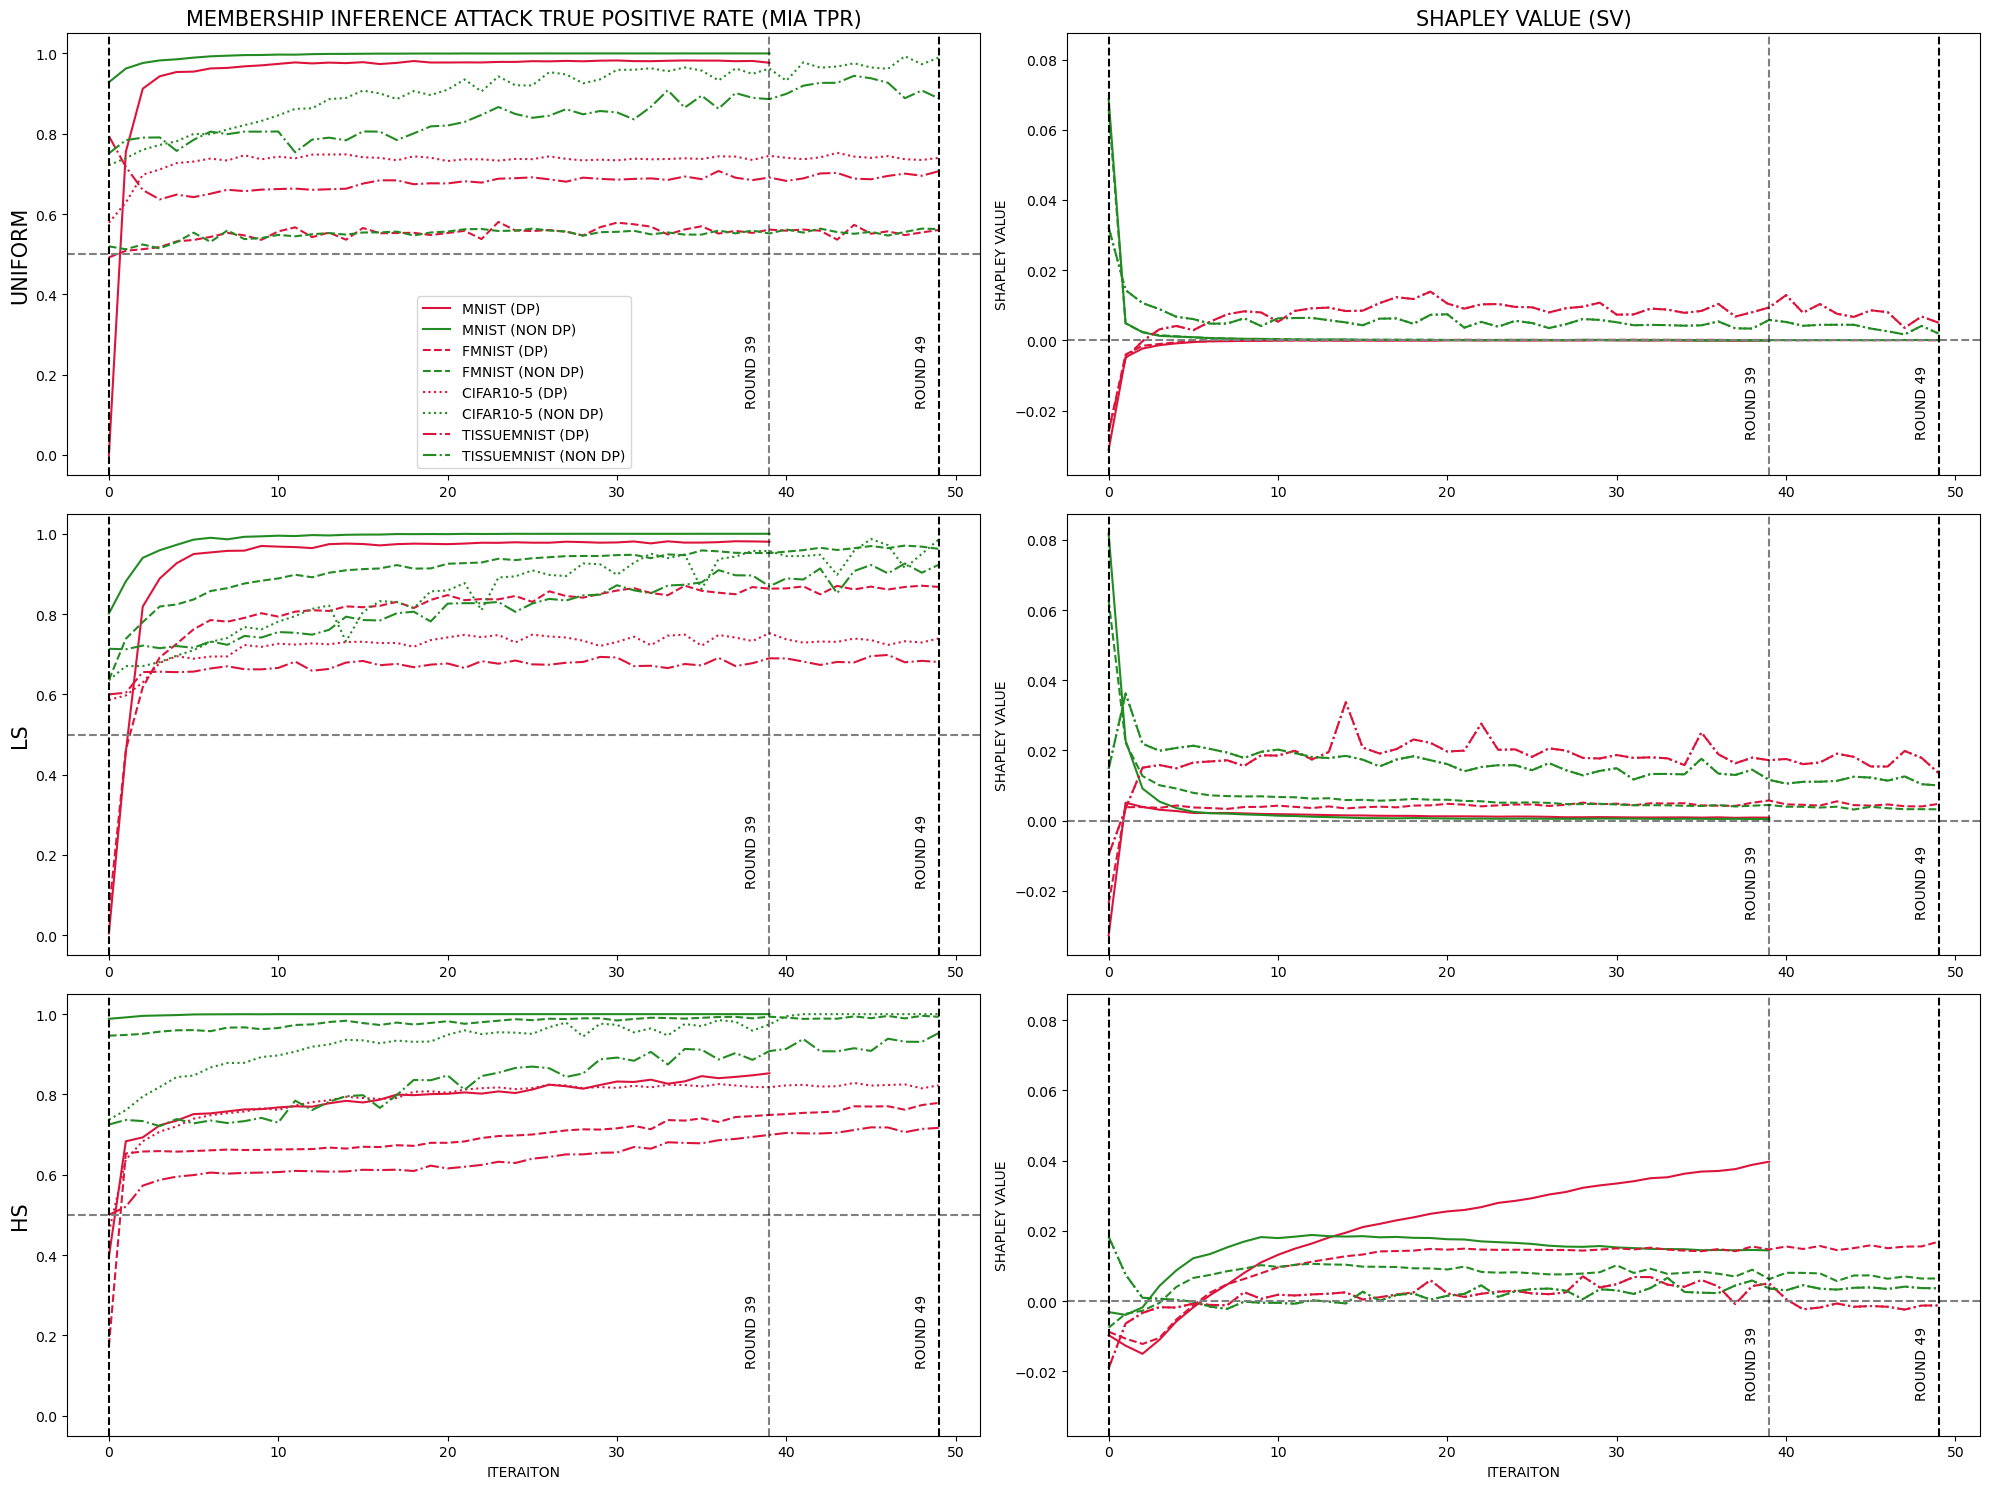

In [20]:
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['with_DP']

client_styles = {
    'mnist': '-',  # Blue
    'fmnist': '--', # Red 
    'cifar10-5': ':',  # Green 
    'tissuemnist': '-.', # Orange 
}


results = load_multiple_contribution_attack_results(
            datasets=datasets,
            scenarios=scenarios,
            versions=versions
)
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

for dataset in datasets:
    if dataset == 'mnist' or dataset == 'fmnist':
        dp_clients = [0, 1, 6]
        non_dp_clients = [2, 3, 4, 5, 7]
    else:
        dp_clients = [0, 4]
        non_dp_clients = [1, 2, 3]
    
    axes[0][0].plot(results[f'uniform_with_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset], label=f"{dataset} (DP)".upper())
    axes[1][0].plot(results[f'ls_with_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    axes[2][0].plot(results[f'hs_with_DP_{dataset}'][[f"{client}_TPR" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
    axes[0][0].plot(results[f'uniform_with_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset], label=f"{dataset} (NON DP)".upper())
    axes[1][0].plot(results[f'ls_with_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    axes[2][0].plot(results[f'hs_with_DP_{dataset}'][[f"{client}_TPR" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
    axes[0][1].plot(results[f'uniform_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    axes[1][1].plot(results[f'ls_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    axes[2][1].plot(results[f'hs_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in dp_clients]].mean(axis=1), color='#DC143C', linestyle=client_styles[dataset])
    
    axes[0][1].plot(results[f'uniform_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    axes[1][1].plot(results[f'ls_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    axes[2][1].plot(results[f'hs_with_DP_{dataset}'][[f"{client}_SHAP_ACC" for client in non_dp_clients]].mean(axis=1), color='#228B22', linestyle=client_styles[dataset])
    
    axes[0,0].legend()
    axes[0,0].set_title("MEMBERSHIP INFERENCE ATTACK TRUE POSITIVE RATE (MIA TPR)", fontsize=15)
    axes[0,1].set_title("SHAPLEY VALUE (SV)", fontsize=15)

    axes[0,0].set_ylabel('UNIFORM', fontsize=15)
    axes[1,0].set_ylabel('LS', fontsize=15)
    axes[2,0].set_ylabel('HS', fontsize=15)

    axes[1][0].sharey(axes[0][0])
    axes[2][0].sharey(axes[0][0])
    axes[1][1].sharey(axes[0][1])
    axes[2][1].sharey(axes[0][1])

x = 49
for i in range(3):
    axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
    axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
    axes[i][0].axvline(x=0, color='black', linestyle='--')
    axes[i][0].axvline(x=39, color='black', linestyle='--', alpha=0.5)
    axes[i][0].axvline(x=x, color='black', linestyle='--')
    axes[i][0].text(38, axes[i][0].get_ylim()[1] * 0.20, 'ROUND 39', 
                    color='black', fontsize=10, ha='center', va='center', rotation=90)
    axes[i][0].text(48, axes[i][0].get_ylim()[1] * 0.20, 'ROUND 49', 
                    color='black', fontsize=10, ha='center', va='center', rotation=90)
    axes[i][1].axvline(x=0, color='black', linestyle='--')
    axes[i][1].axvline(x=39, color='black', linestyle='--', alpha=0.5)
    axes[i][1].axvline(x=x, color='black', linestyle='--')
    axes[i][1].text(38, axes[i][1].get_ylim()[1] * (-0.2), 'ROUND 39', 
                    color='black', fontsize=10, ha='center', va='center', rotation=90)
    axes[i][1].text(48, axes[i][1].get_ylim()[1] * (-0.2), 'ROUND 49', 
                    color='black', fontsize=10, ha='center', va='center', rotation=90)
for i in range(2):
    axes[2][i].set_xlabel("ITERAITON")
for i in range(3):
    axes[i][1].set_ylabel("SHAPLEY VALUE")

if version == 'with_DP':
    suptitle = "(SOME CLIENTS WITH DP)"
else:
    suptitle = "(WITHOUT ANY DP)"
#fig.suptitle(f"{dataset.upper()} {suptitle}", fontsize=20)

fig.tight_layout()

# 5.3.2. Stationarity Analysis

In [21]:
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']

versions = ['with_DP', 'without_DP']

results= load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)

for dataset in datasets:
    for scenario in scenarios:
        for version in versions:
            if dataset == 'mnist' or dataset == 'fmnist':
                no_clients = 8
            else:
                no_clients = 5
            stats = calculate_single_stationarity(
                no_clients=no_clients,
                frame=results[f"{scenario}_{version}_{dataset}"]
            )
            root = os.path.join(os.getcwd(), 'tables', 'stationarity')
            with open(os.path.join(root, f"{scenario}_{version}_{dataset}.tex"), 'w') as file:
                file.write(stats.to_latex())

c:\Users\macie\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\macie\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\macie\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\macie\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\macie\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr /

# 5.3.3. Correlation Tests (Pearson)

In [33]:
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']

versions = ['with_DP', 'without_DP']

results= load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)

for dataset in datasets:
    if dataset == 'mnist' or dataset == 'fmnist':
        no_clients = 8
    else:
        no_clients = 5
    for version in versions:
        correlation_tests = pd.DataFrame(index=range(no_clients), columns=['uniform coef', 'uniform p-value', 'ls coef', 'ls p-value', 'hs coef', 'hs p-value'])
        for scenario in scenarios:
            stats = calculate_single_corr_short(
                no_clients=no_clients,
                frame=results[f"{scenario}_{version}_{dataset}"],
                mode='pearson'
            )
            correlation_tests[f"{scenario} coef"] = stats['TPR_TO_SHAP_F1SCORE']
            correlation_tests[f"{scenario} p-value"] = stats['TPR_TO_SHAP_F1SCORE P-VALUE']
        root = os.path.join(os.getcwd(), 'tables', 'correlations', 'pearson')
        with open(os.path.join(root, f"{version}_{dataset}.tex"), 'w') as file:
            file.write(correlation_tests.to_latex())

# 5.3.3. Correlation Tests (Spearmann)

In [32]:
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']

versions = ['with_DP', 'without_DP']

results= load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)

for dataset in datasets:
    if dataset == 'mnist' or dataset == 'fmnist':
        no_clients = 8
    else:
        no_clients = 5
    for version in versions:
        correlation_tests = pd.DataFrame(index=range(no_clients), columns=['uniform coef', 'uniform p-value', 'ls coef', 'ls p-value', 'hs coef', 'hs p-value'])
        for scenario in scenarios:
            stats = calculate_single_corr_short(
                no_clients=no_clients,
                frame=results[f"{scenario}_{version}_{dataset}"],
                mode='spearman'
            )
            correlation_tests[f"{scenario} coef"] = stats['TPR_TO_SHAP_F1SCORE']
            correlation_tests[f"{scenario} p-value"] = stats['TPR_TO_SHAP_F1SCORE P-VALUE']
        root = os.path.join(os.getcwd(), 'tables', 'correlations', 'spearman')
        with open(os.path.join(root, f"{version}_{dataset}.tex"), 'w') as file:
            file.write(correlation_tests.to_latex())

# 5.3.4. Cross-Correlation Tests

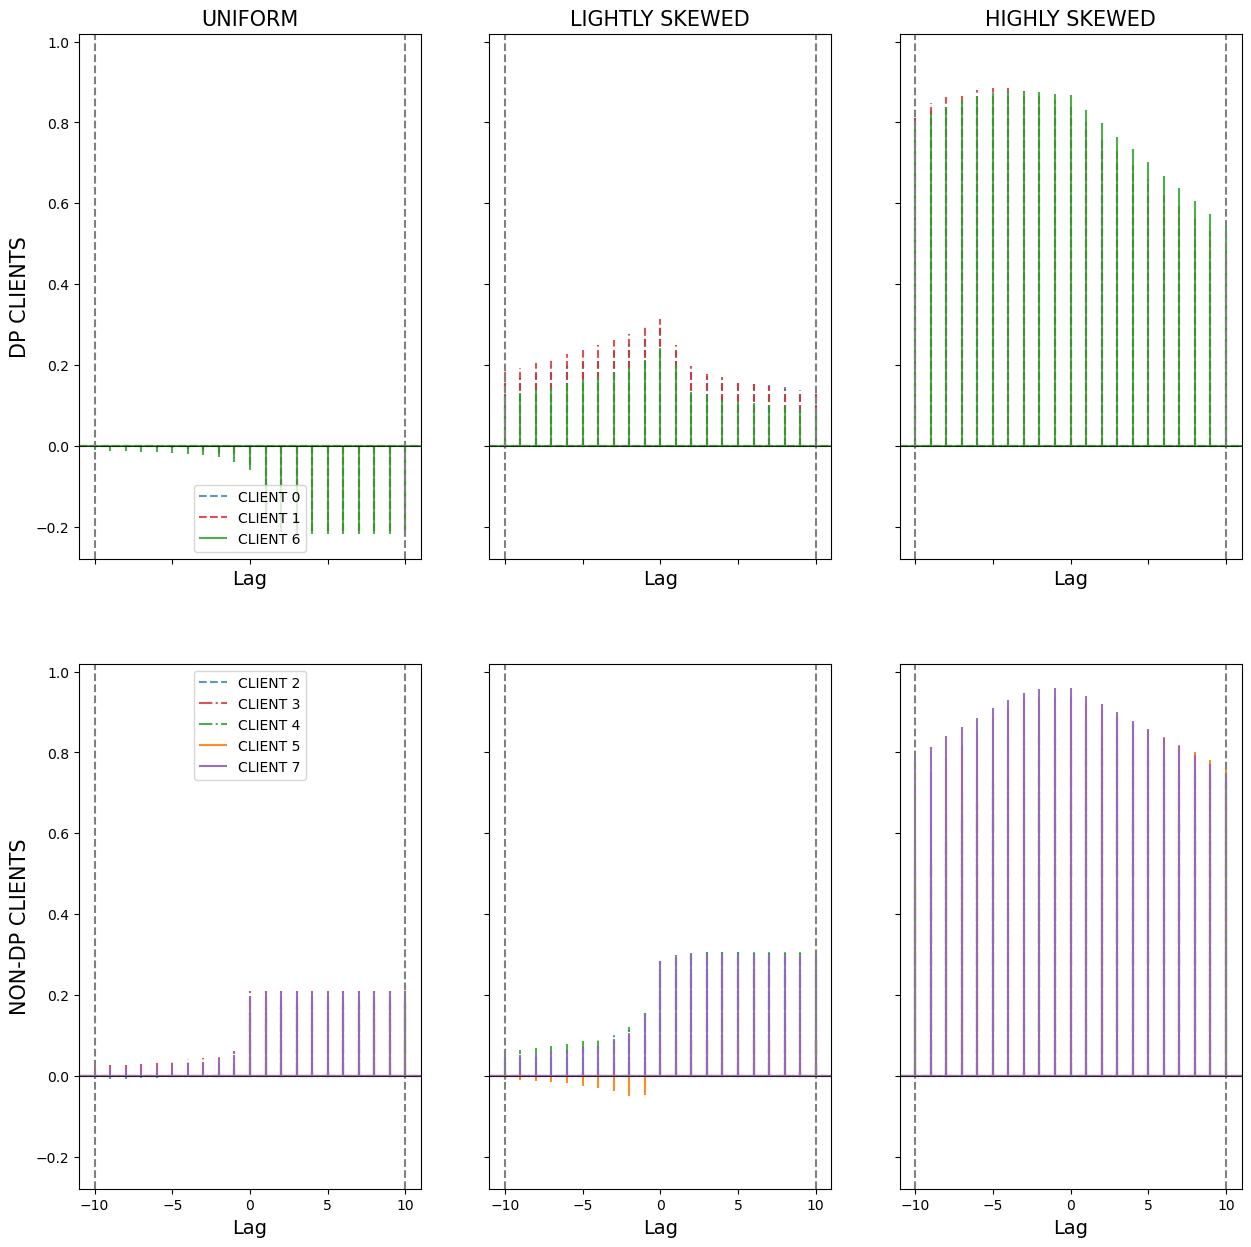

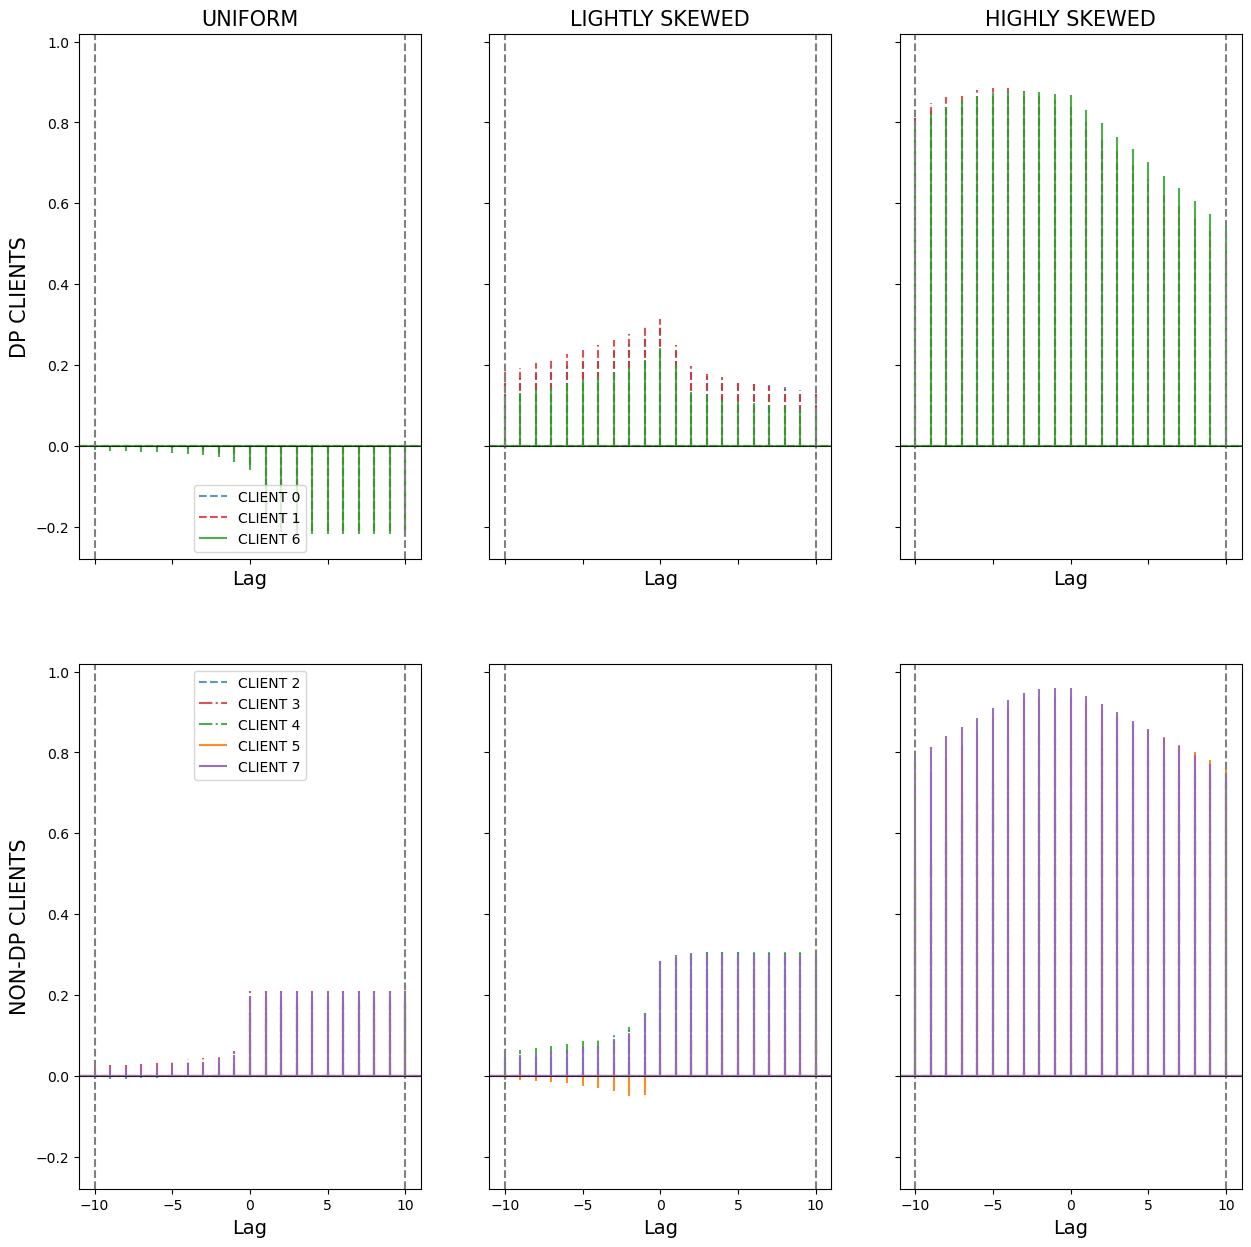

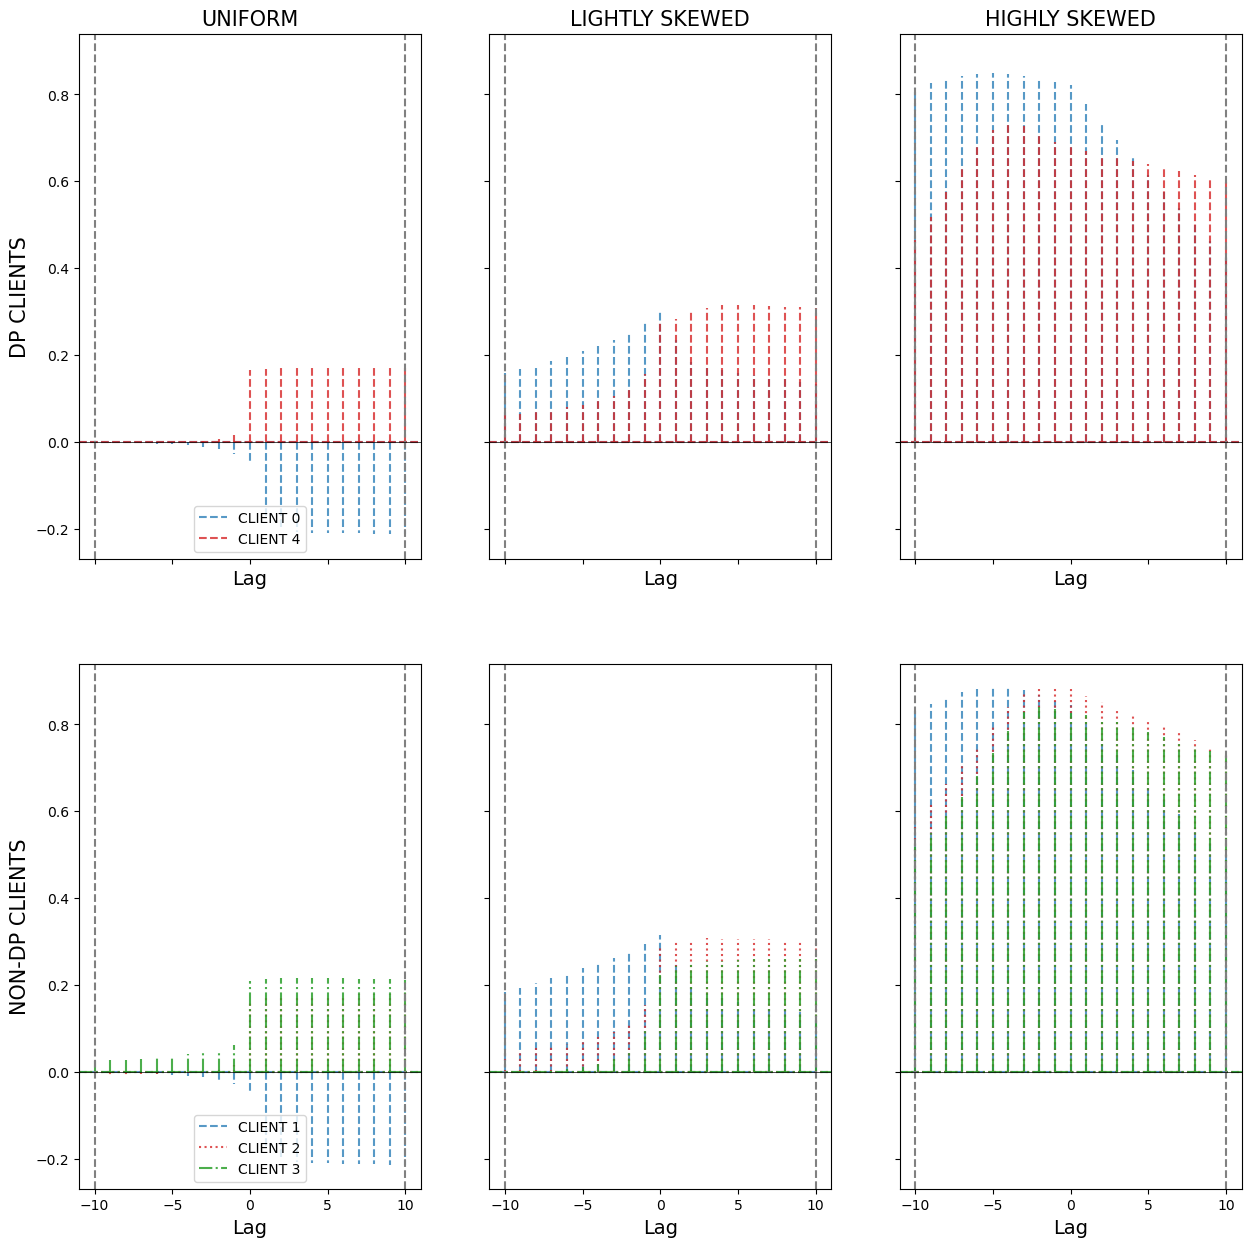

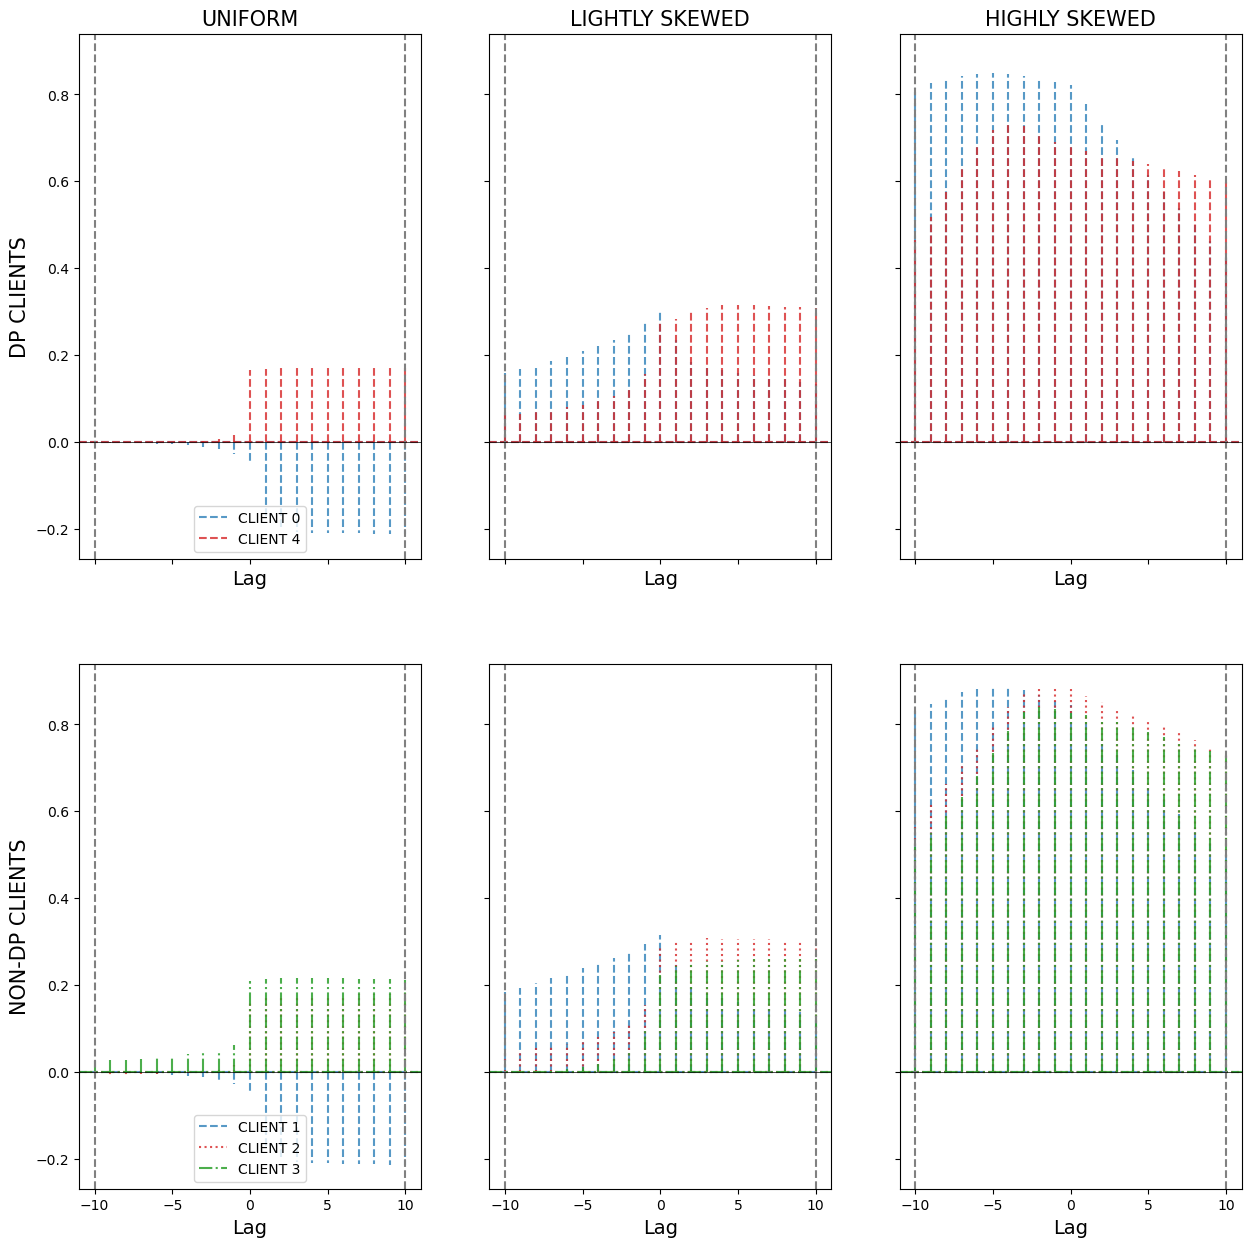

In [63]:
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['with_DP']

client_styles = {
    0: ('#E6194B', '-'),   # Red (Solid)
    1: ('#FF7F0E', '--'),  # Dark Orange (Dashed)
    2: ('#FFD700', ':'),   # Golden Yellow (Dotted)
    3: ('#FF6347', '-.'),  # Tomato Red (Dash-Dot)
    4: ('#1F77B4', '-'),   # Blue (Solid)
    5: ('#17BECF', '--'),  # Teal (Dashed)
    6: ('#9467BD', ':'),   # Purple (Dotted)
    7: ('#2CA02C', '-.')   # Dark Green (Dash-Dot)
}

with_DP = load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)

for dataset in datasets:
    fig, axes = plt.subplots(2, 3, figsize=(15, 15), sharex=True, sharey=True)
    if dataset == 'mnist' or dataset == 'fmnist':
        dp_clients = [0, 1, 6]
        non_dp_clients = [2, 3, 4, 5, 7]
        client_styles = {
            0: ('#1F77B4', '--'),   # Blue (Dashed)
            1: ('#D62728', '--'),   # Red (Dashed)
            2: ('#1F77B4', '--'),   # Blue (Dashed)
            3: ('#D62728', '-.'),   # Red (Dash-Dot)
            4: ('#2CA02C', '-.'),   # Green (Dash-Dot)
            5: ('#FF7F0E', '-'),   # Orange (Solid)
            6: ('#2CA02C', '-'),    # Green (Solid)
            7: ('#9467BD', '-')    # Purple (Solid)
        }
    else:
        dp_clients = [0, 4]
        non_dp_clients = [1, 2, 3]
        client_styles = {
            0: ('#1F77B4', '--'),  # Blue (Dashed)
            1: ('#1F77B4', '--'),  # Blue (Dashed)
            2: ('#D62728', ':'),   # Red (Dot)
            3: ('#2CA02C', '-.'),  # Tomato Red (Dash-Dot)
            4: ('#D62728', '--'),   # Red (Dashed)
        }
    for index, scenario in enumerate(scenarios):
        alpha = 0.75
        for client in dp_clients:
            series_A = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_TPR"]
            series_B = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_SHAP_F1SCORE"]
            axes[0][index].xcorr(series_A, series_B, maxlags=10, normed=True, color=client_styles[client][0], linestyle=client_styles[client][1], alpha=alpha, label=f'CLIENT {client}')
            alpha += 0.05
        alpha = 0.75
        for client in non_dp_clients:
            series_A = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_TPR"]
            series_B = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_SHAP_F1SCORE"]
            axes[1][index].xcorr(series_A, series_B, maxlags=10, normed=True, color=client_styles[client][0], linestyle=client_styles[client][1], alpha=alpha, label=f'CLIENT {client}')
            alpha += 0.05
        axes[0][index].axvline(x=-10, color='gray', linestyle='--')
        axes[0][index].axvline(x=10, color='gray', linestyle='--')
        axes[1][index].axvline(x=-10, color='gray', linestyle='--')
        axes[1][index].axvline(x=10, color='gray', linestyle='--')
        axes[0][index].axhline(y=0, color='black', linewidth=0.5)
        axes[1][index].axhline(y=0, color='black', linewidth=0.5)
        axes[0][index].set_xlabel("Lag", fontsize = 14)
        axes[1][index].set_xlabel("Lag", fontsize = 14)

    axes[0][0].legend()
    axes[1][0].legend()
    axes[0,0].set_ylabel('DP CLIENTS', fontsize=15)
    axes[1,0].set_ylabel('NON-DP CLIENTS', fontsize=15)
    axes[0,0].set_title("UNIFORM", fontsize=15)
    axes[0,1].set_title("LIGHTLY SKEWED", fontsize=15)
    axes[0,2].set_title("HIGHLY SKEWED", fontsize=15)